# BCGX PowerCo Churn Analysis and Modeling

This project was completed as a part of BCG Data Science Job Simulation. Task for this project is to assist client PowerCo in churn analysis and modeling and analyze whether Price Senstivity is a major contributing factor for Customer Churn. Price Senstivity is defined as Change in Demand/Change in Price for this project. Throughout the project we followed BCGX guidance and completed steps as a Data Scientist would during the job at BCG.

Besides that, we have performed our own additional EDA and Churn Modeling, with our best model better than BCGX Model Answer by several times, five time better in F1 Score and 10 times better in recall performance as BCGX used a simple Random Forest while we used Gradient Boosting algorithm with hyper parameter tuning, Dense Neueral Network, and a BiDirectional LSTM-CNN models. Among them XGBoost model performed best and this corresponds to the industry norm where gradient boosting and other boosting algorithms worked better in structured tabular dataset, provided that we have limited data.

This project will be divided into following steps:
1. EDA and Feature Engineering
2. Model Training, Hyperparameter Tuning, and Evaluation
3. Conclusion

## EDA and Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering alongside indepth Analysis

---

## 1. Import packages

In [1]:
#required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential 
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

---
## 2. Load data

We have been given two datasets for this task. One contain Clients data and other contains Monthly Price data for clients over an year.Through out the EDA we will cover all the necessary columns for both datasets. 

In [ ]:
EDA and Feature Engineering

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [4]:
#We will start with overall churn rate
df_temp_churn = df['churn'].value_counts(normalize = True).reset_index()
df_temp_churn

,churn,proportion
0,0,0.902848
1,1,0.097152


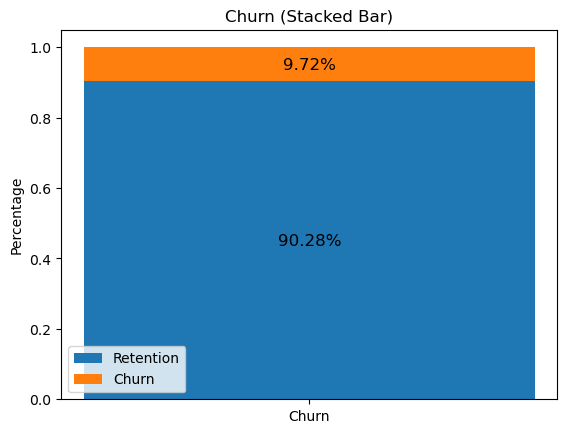

In [5]:
#before going further we will see the churn percentages

plt.bar('Churn', df_temp_churn.iloc[0,1], label = 'Retention')
plt.bar('Churn', df_temp_churn.iloc[1,1], bottom = df_temp_churn.iloc[0,1] ,label = 'Churn')
plt.ylabel('Percentage')
plt.title('Churn (Stacked Bar)')
plt.text('Churn', df_temp_churn.iloc[0,1]/2, f"{df_temp_churn.iloc[0,1]:.2%}", ha='center', va='center', color='black', fontsize=12)
plt.text('Churn', df_temp_churn.iloc[0,1] + df_temp_churn.iloc[1,1]/2, f"{df_temp_churn.iloc[1,1]:.2%}", ha='center', va='center', color='black', fontsize=12)
plt.legend()
plt.show()

Overall, we have 9.72% churn rate which is more than what client expected. Our goal of this analysis is to study the dataset, observe the relationship between Churn and predictors, and make a predictive model for the client.

### Date Analysis

In [6]:
#Analyzing dates data
df['tenure'] = (df['date_end'] - df['date_activ']).dt.days #creating tenure parameter

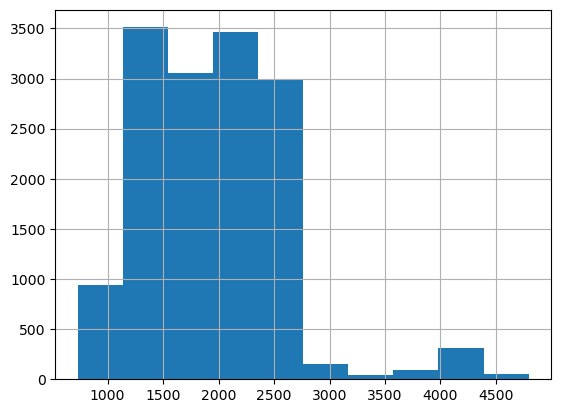

In [7]:
df['tenure'].hist()
plt.show()

In [8]:
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distribution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

In [9]:
#Columns deemed not necessary for the task
df.drop(columns = ['date_modif_prod', 'date_renewal'], inplace = True)

In [10]:
#creating ending month column to see if some months have more churn than others
df['end_month'] = df['date_end'].dt.month
df.drop(columns = ['date_activ', 'date_end'], inplace = True)

end_month
1     112
2     149
3     124
4      94
5     108
6     143
7      89
8     111
9      98
10    139
11    143
12    109
Name: churn, dtype: int64


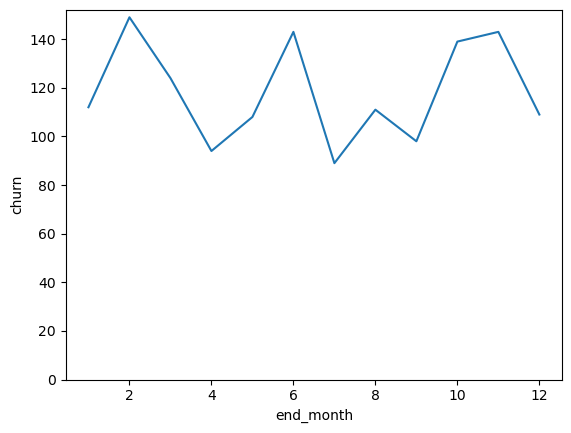

In [11]:
print(df.groupby('end_month').sum()['churn'])
sns.lineplot(data = df.groupby('end_month').sum()['churn'].reset_index(), x = 'end_month', y = 'churn')
plt.ylim(bottom = 0)
plt.show()

We are able to see three modes or peaks for churns happening across the years, February, June, and November. This signify that while churn happens across the year it peaks at the start of the year, in middle, and then in the end of the year with little variablity across them.

### Consumption Variables

In [12]:
df.filter(regex = '^cons_').corr()

,cons_12m,cons_gas_12m,cons_last_month
cons_12m,1.000000,0.488474,0.968212
cons_gas_12m,0.488474,1.000000,0.507007
cons_last_month,0.968212,0.507007,1.000000


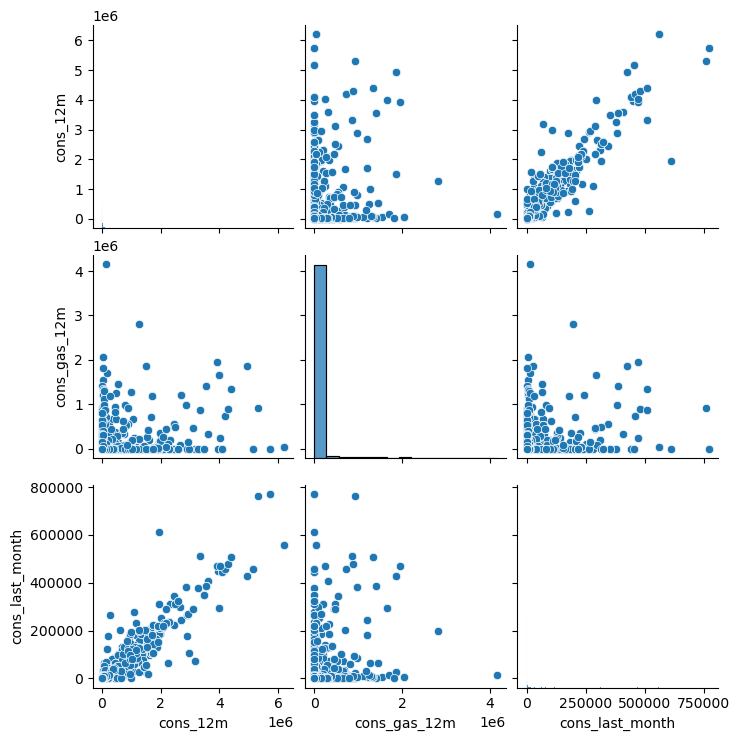

In [13]:
sns.pairplot(df.filter(regex = '^cons_'))
plt.show()

In [14]:
df.filter(regex = '^cons_').corr()

,cons_12m,cons_gas_12m,cons_last_month
cons_12m,1.000000,0.488474,0.968212
cons_gas_12m,0.488474,1.000000,0.507007
cons_last_month,0.968212,0.507007,1.000000


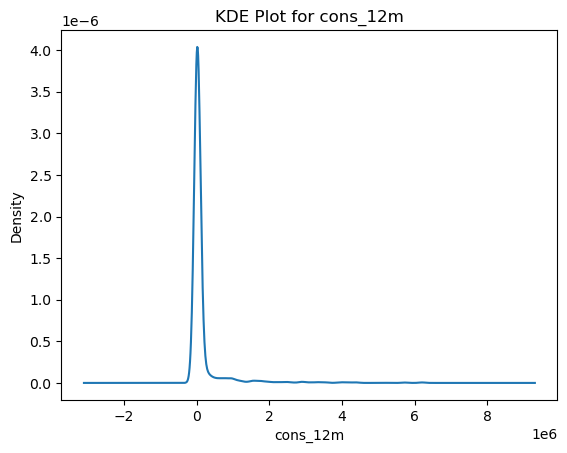

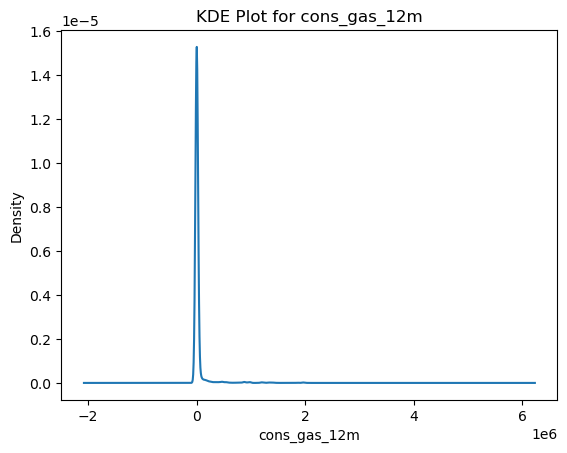

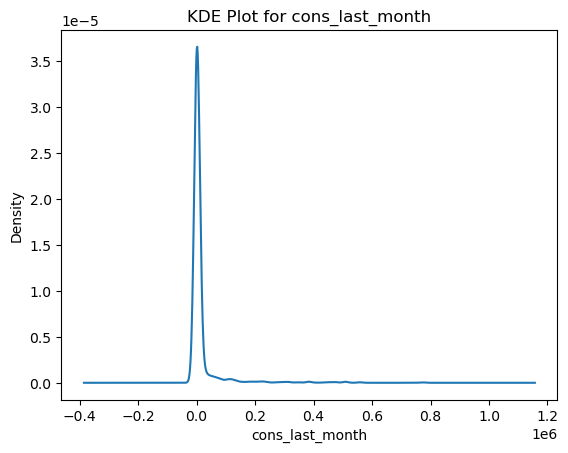

In [15]:
for col in df.filter(regex = '^cons_'):
    df[col].plot.kde()
    plt.title(f'KDE Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

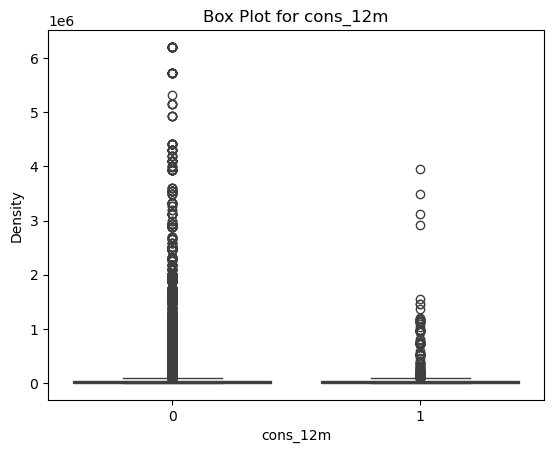

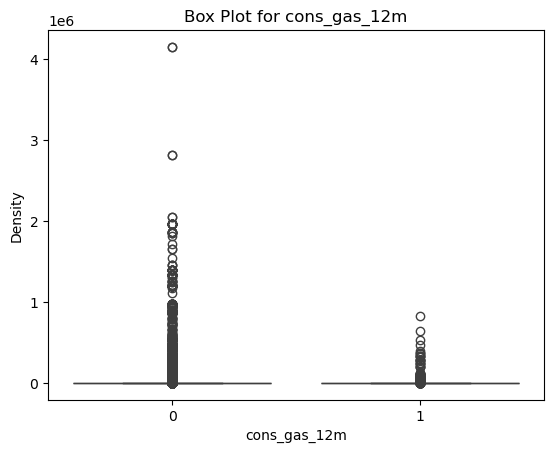

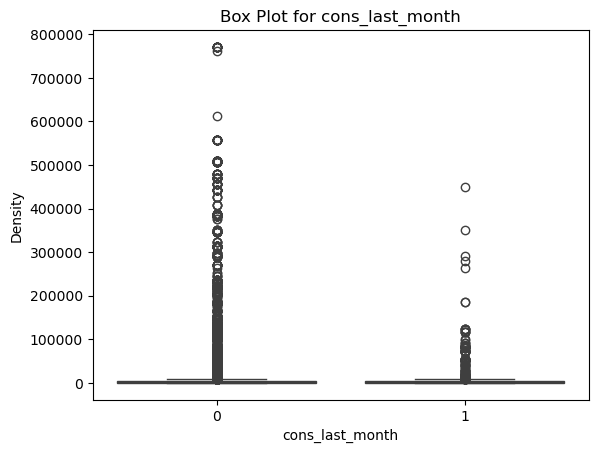

In [16]:
for col in df.filter(regex = '^cons_'):
    plt.figure()
    sns.boxplot(x = df['churn'], y = df[col])
    plt.title(f'Box Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

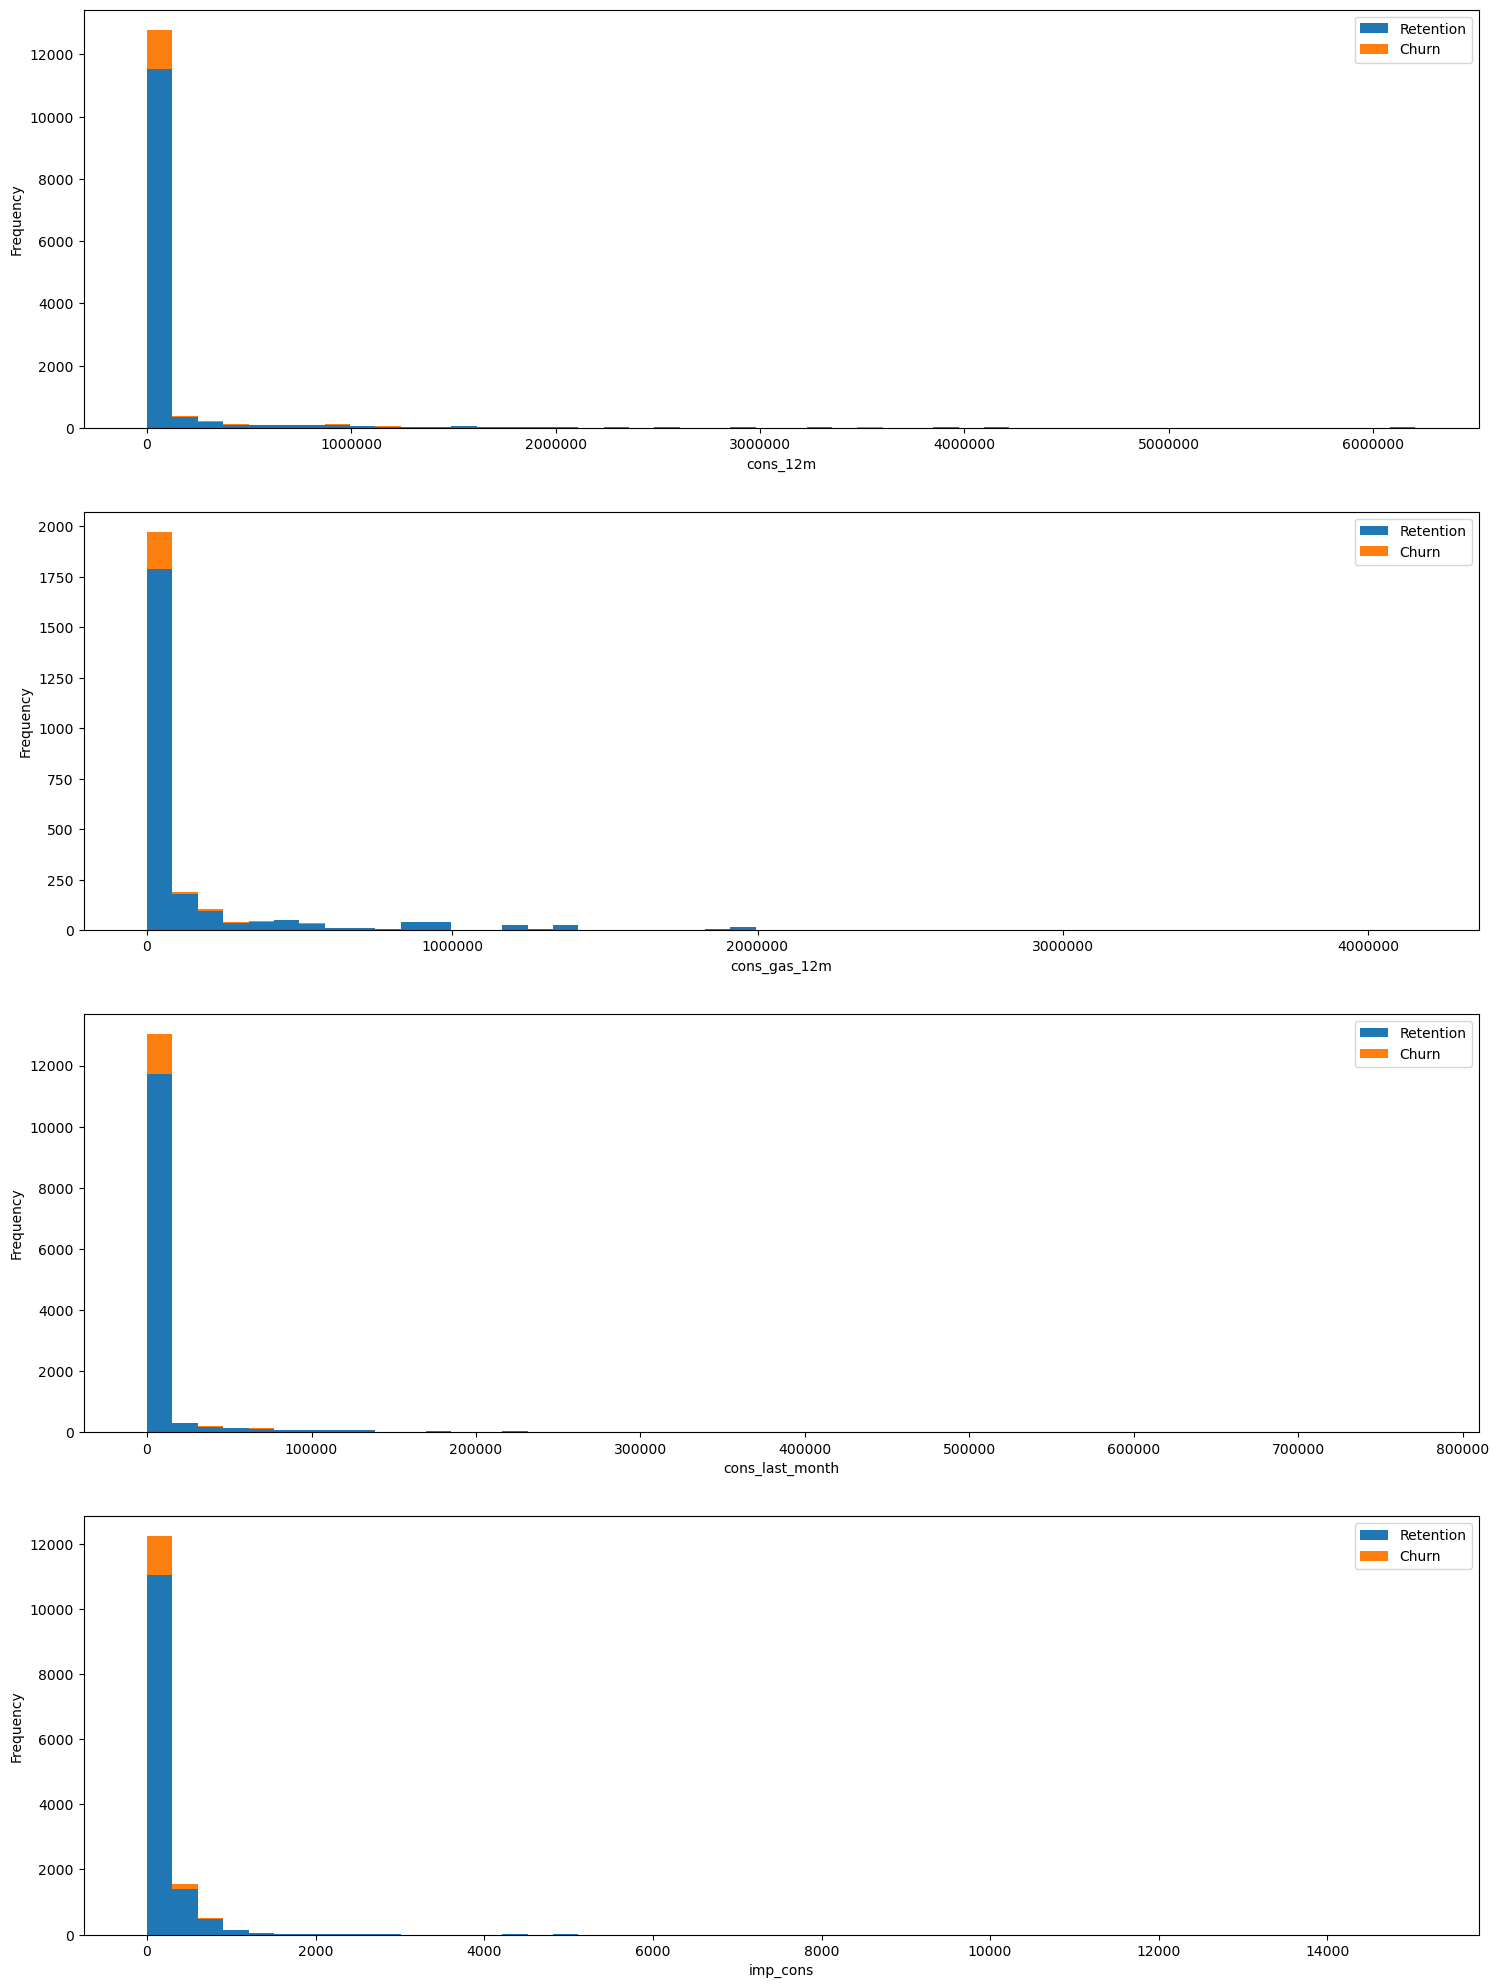

In [17]:
fig, axs = plt.subplots(nrows=4, figsize=(18, 25))

plot_distribution(df, 'cons_12m', axs[0])
plot_distribution(df[df['has_gas'] == 't'], 'cons_gas_12m', axs[1])
plot_distribution(df, 'cons_last_month', axs[2])
plot_distribution(df, 'imp_cons', axs[3])
plt.show()

In [18]:
df.filter(regex = '^cons_').describe()

,cons_12m,cons_gas_12m,cons_last_month
count,1.460600e+04,1.460600e+04,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752
std,5.734653e+05,1.629731e+05,64364.196422
min,0.000000e+00,0.000000e+00,0.000000
25%,5.674750e+03,0.000000e+00,0.000000
50%,1.411550e+04,0.000000e+00,792.500000
75%,4.076375e+04,0.000000e+00,3383.000000
max,6.207104e+06,4.154590e+06,771203.000000


Consumption Variables are right skewed with most churns happening with customers with low consumption overall. Nevertheless, variables are highly skewed and there are a lot of outliers, and on top of that we are indeed in need for normalization for this dataset as range vary a lot across different categories.

### Forecast

In [19]:
df.filter(regex = 'forecast_').describe()

,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [20]:
df.filter(regex = 'forecast_').corr()

,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
forecast_cons_12m,1.000000,0.647727,0.058435,0.305627,-0.135646,0.254056,-0.018477
forecast_cons_year,0.647727,1.000000,0.008518,0.276009,-0.158012,0.251005,-0.044190
forecast_discount_energy,0.058435,0.008518,1.000000,-0.008388,0.353735,0.059318,0.048024
forecast_meter_rent_12m,0.305627,0.276009,-0.008388,1.000000,-0.579353,0.706376,-0.203089
forecast_price_energy_off_peak,-0.135646,-0.158012,0.353735,-0.579353,1.000000,-0.330138,0.630377
forecast_price_energy_peak,0.254056,0.251005,0.059318,0.706376,-0.330138,1.000000,-0.242017
forecast_price_pow_off_peak,-0.018477,-0.044190,0.048024,-0.203089,0.630377,-0.242017,1.000000


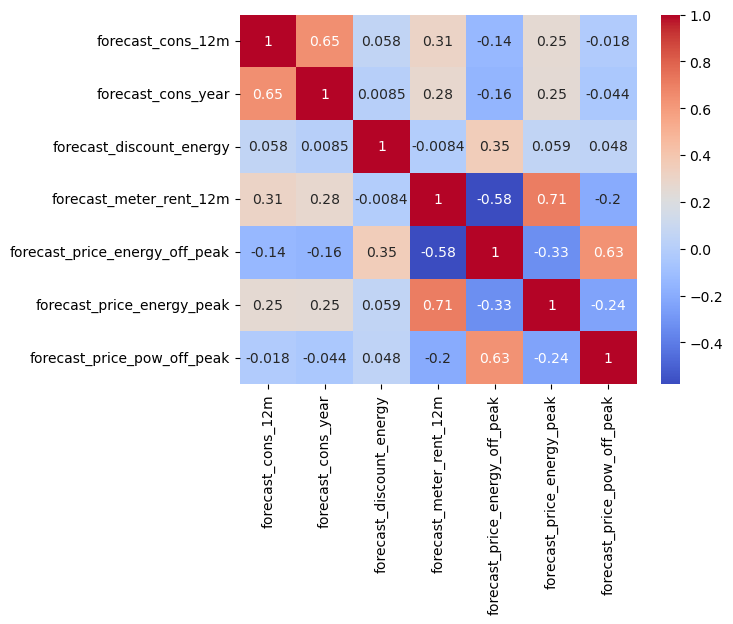

In [21]:
sns.heatmap(df.filter(regex = 'forecast_').corr(), cmap = 'coolwarm', annot = True)
plt.show()

In [22]:
# Removing forecasted yearly consumption valuue as we will use 12 month forecast
df.drop(columns = 'forecast_cons_year', inplace = True)

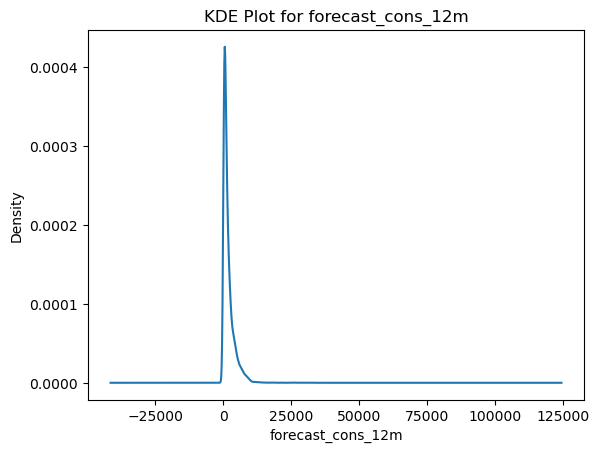

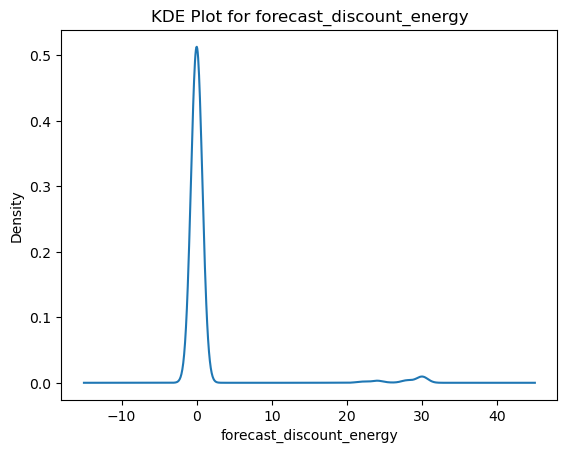

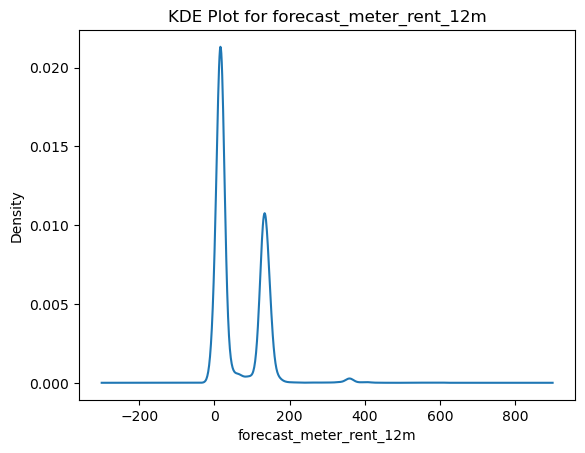

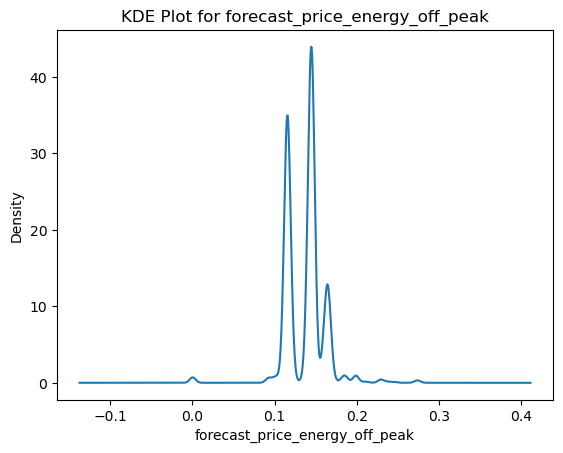

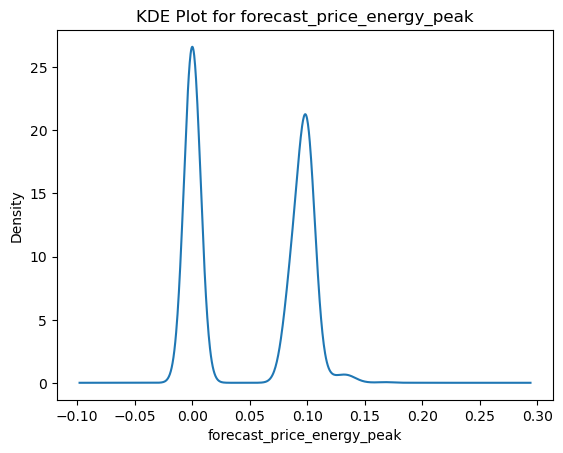

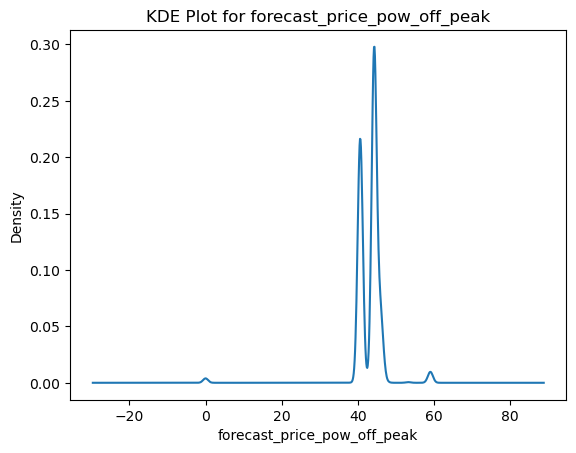

In [23]:
for col in df.filter(regex = '^forecast_'):
    df[col].plot.kde()
    plt.title(f'KDE Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

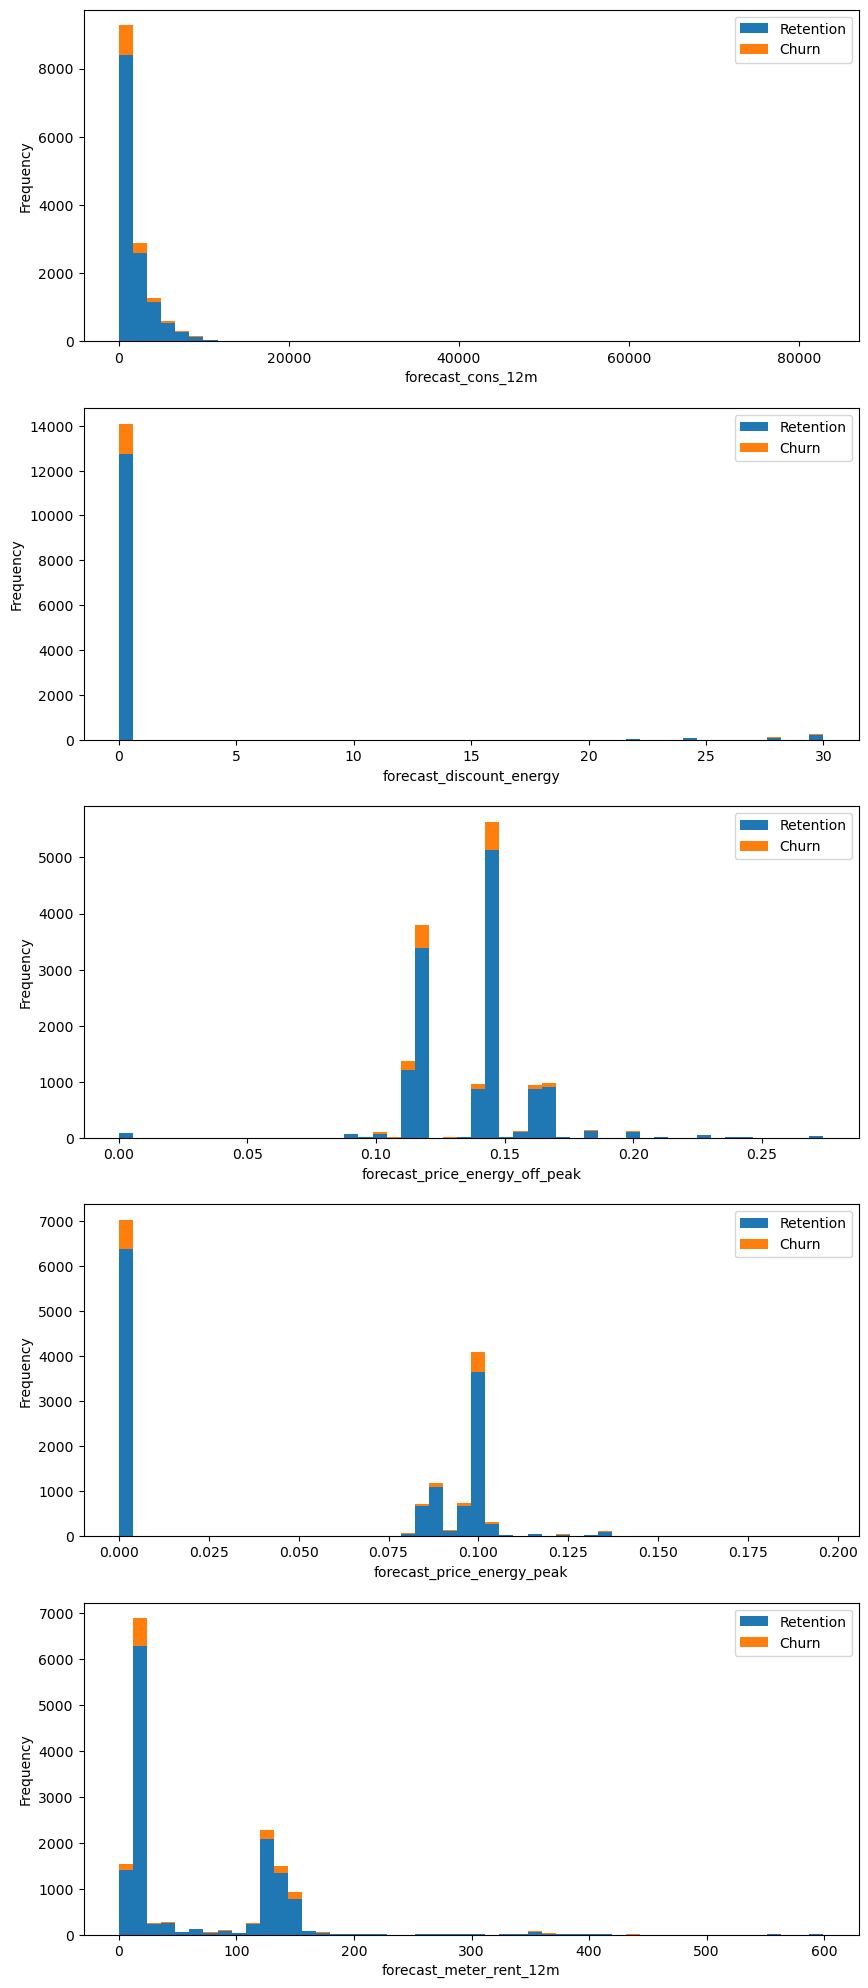

In [24]:
fig, axs = plt.subplots(nrows=5, figsize=(10, 25))

plot_distribution(df, 'forecast_cons_12m', axs[0])
plot_distribution(df, 'forecast_discount_energy', axs[1])
plot_distribution(df, 'forecast_price_energy_off_peak', axs[2])
plot_distribution(df, 'forecast_price_energy_peak', axs[3])
plot_distribution(df, 'forecast_meter_rent_12m', axs[4])                
plt.show()

In [25]:
df.filter(regex = '^forecast_').describe()

,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1868.614880,0.966726,63.086871,0.137283,0.050491,43.130056
std,2387.571531,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,494.995000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1112.875000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,2401.790000,0.000000,131.030000,0.146348,0.098837,44.311378
max,82902.830000,30.000000,599.310000,0.273963,0.195975,59.266378


Just like consumption data we have highly skewed variables for forecasting, which was expected. Our concern is why energy price for peak period is less than off peak periods. It should have been reversed, need confirmation if data was ported properly.

### Others

Before analyzing other variables further it should be noted that variables covering variance of price over the period has been provided by BCGX without relevant mention in the datacard. We will cover them in brief besides other variables.

In [26]:
df['has_gas'] = df['has_gas'].replace(['t','f'], [1,0])

/tmp/ipykernel_153168/2844197130.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_gas'] = df['has_gas'].replace(['t','f'], [1,0])


In [27]:
#we have around 18% of observations with gas connection
print(df.loc[df['has_gas'] == 1,:].shape[0]/df.shape[0])

0.18150075311515815


In [28]:
df.loc[df['has_gas'] == 1,:]['churn'].value_counts(normalize = True)

churn
0    0.918144
1    0.081856
Name: proportion, dtype: float64

In [29]:
df['churn'].value_counts(normalize = True)

churn
0    0.902848
1    0.097152
Name: proportion, dtype: float64

Churn rate for is quite lower for customers with gas connection.

In [30]:
#As expected gross and net margin are highly correlated. We will remove net margin for power subscription
print(df.filter(regex = 'margin').corr())
df.drop(columns = 'margin_net_pow_ele', inplace = True)

                      margin_gross_pow_ele  margin_net_pow_ele  net_margin
margin_gross_pow_ele              1.000000            0.999914    0.031814
margin_net_pow_ele                0.999914            1.000000    0.031639
net_margin                        0.031814            0.031639    1.000000


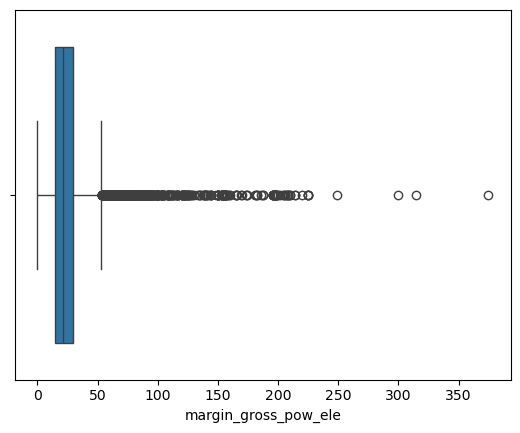

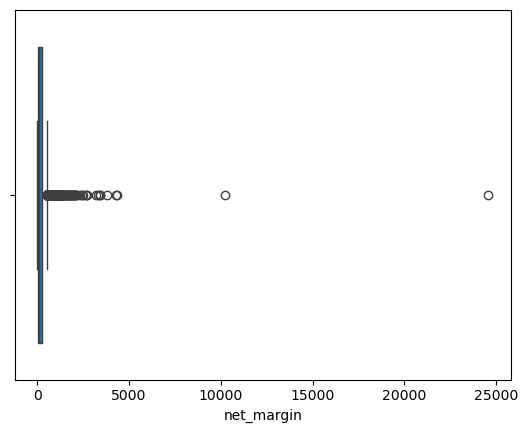

In [31]:
for cols in df.filter(regex = 'margin'):
    sns.boxplot(x = df[cols])
    plt.show()

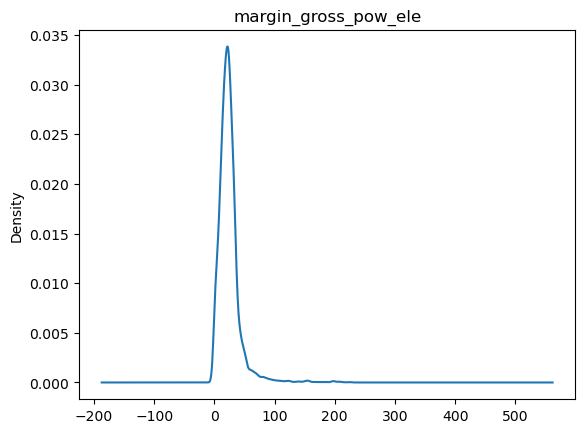

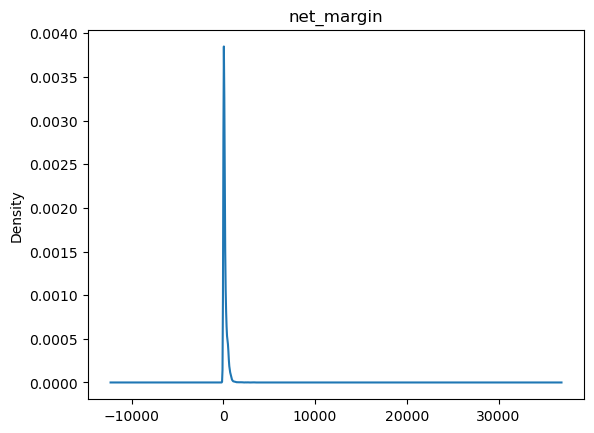

In [32]:
for cols in df.filter(regex = 'margin'):
    df[cols].plot.kde()
    plt.title(f'{cols}')
    plt.show()

In [33]:
df.filter(regex = 'margin').describe()

,margin_gross_pow_ele,net_margin
count,14606.000000,14606.000000
mean,24.565121,189.264522
std,20.231172,311.798130
min,0.000000,0.000000
25%,14.280000,50.712500
50%,21.640000,112.530000
75%,29.880000,243.097500
max,374.640000,24570.650000


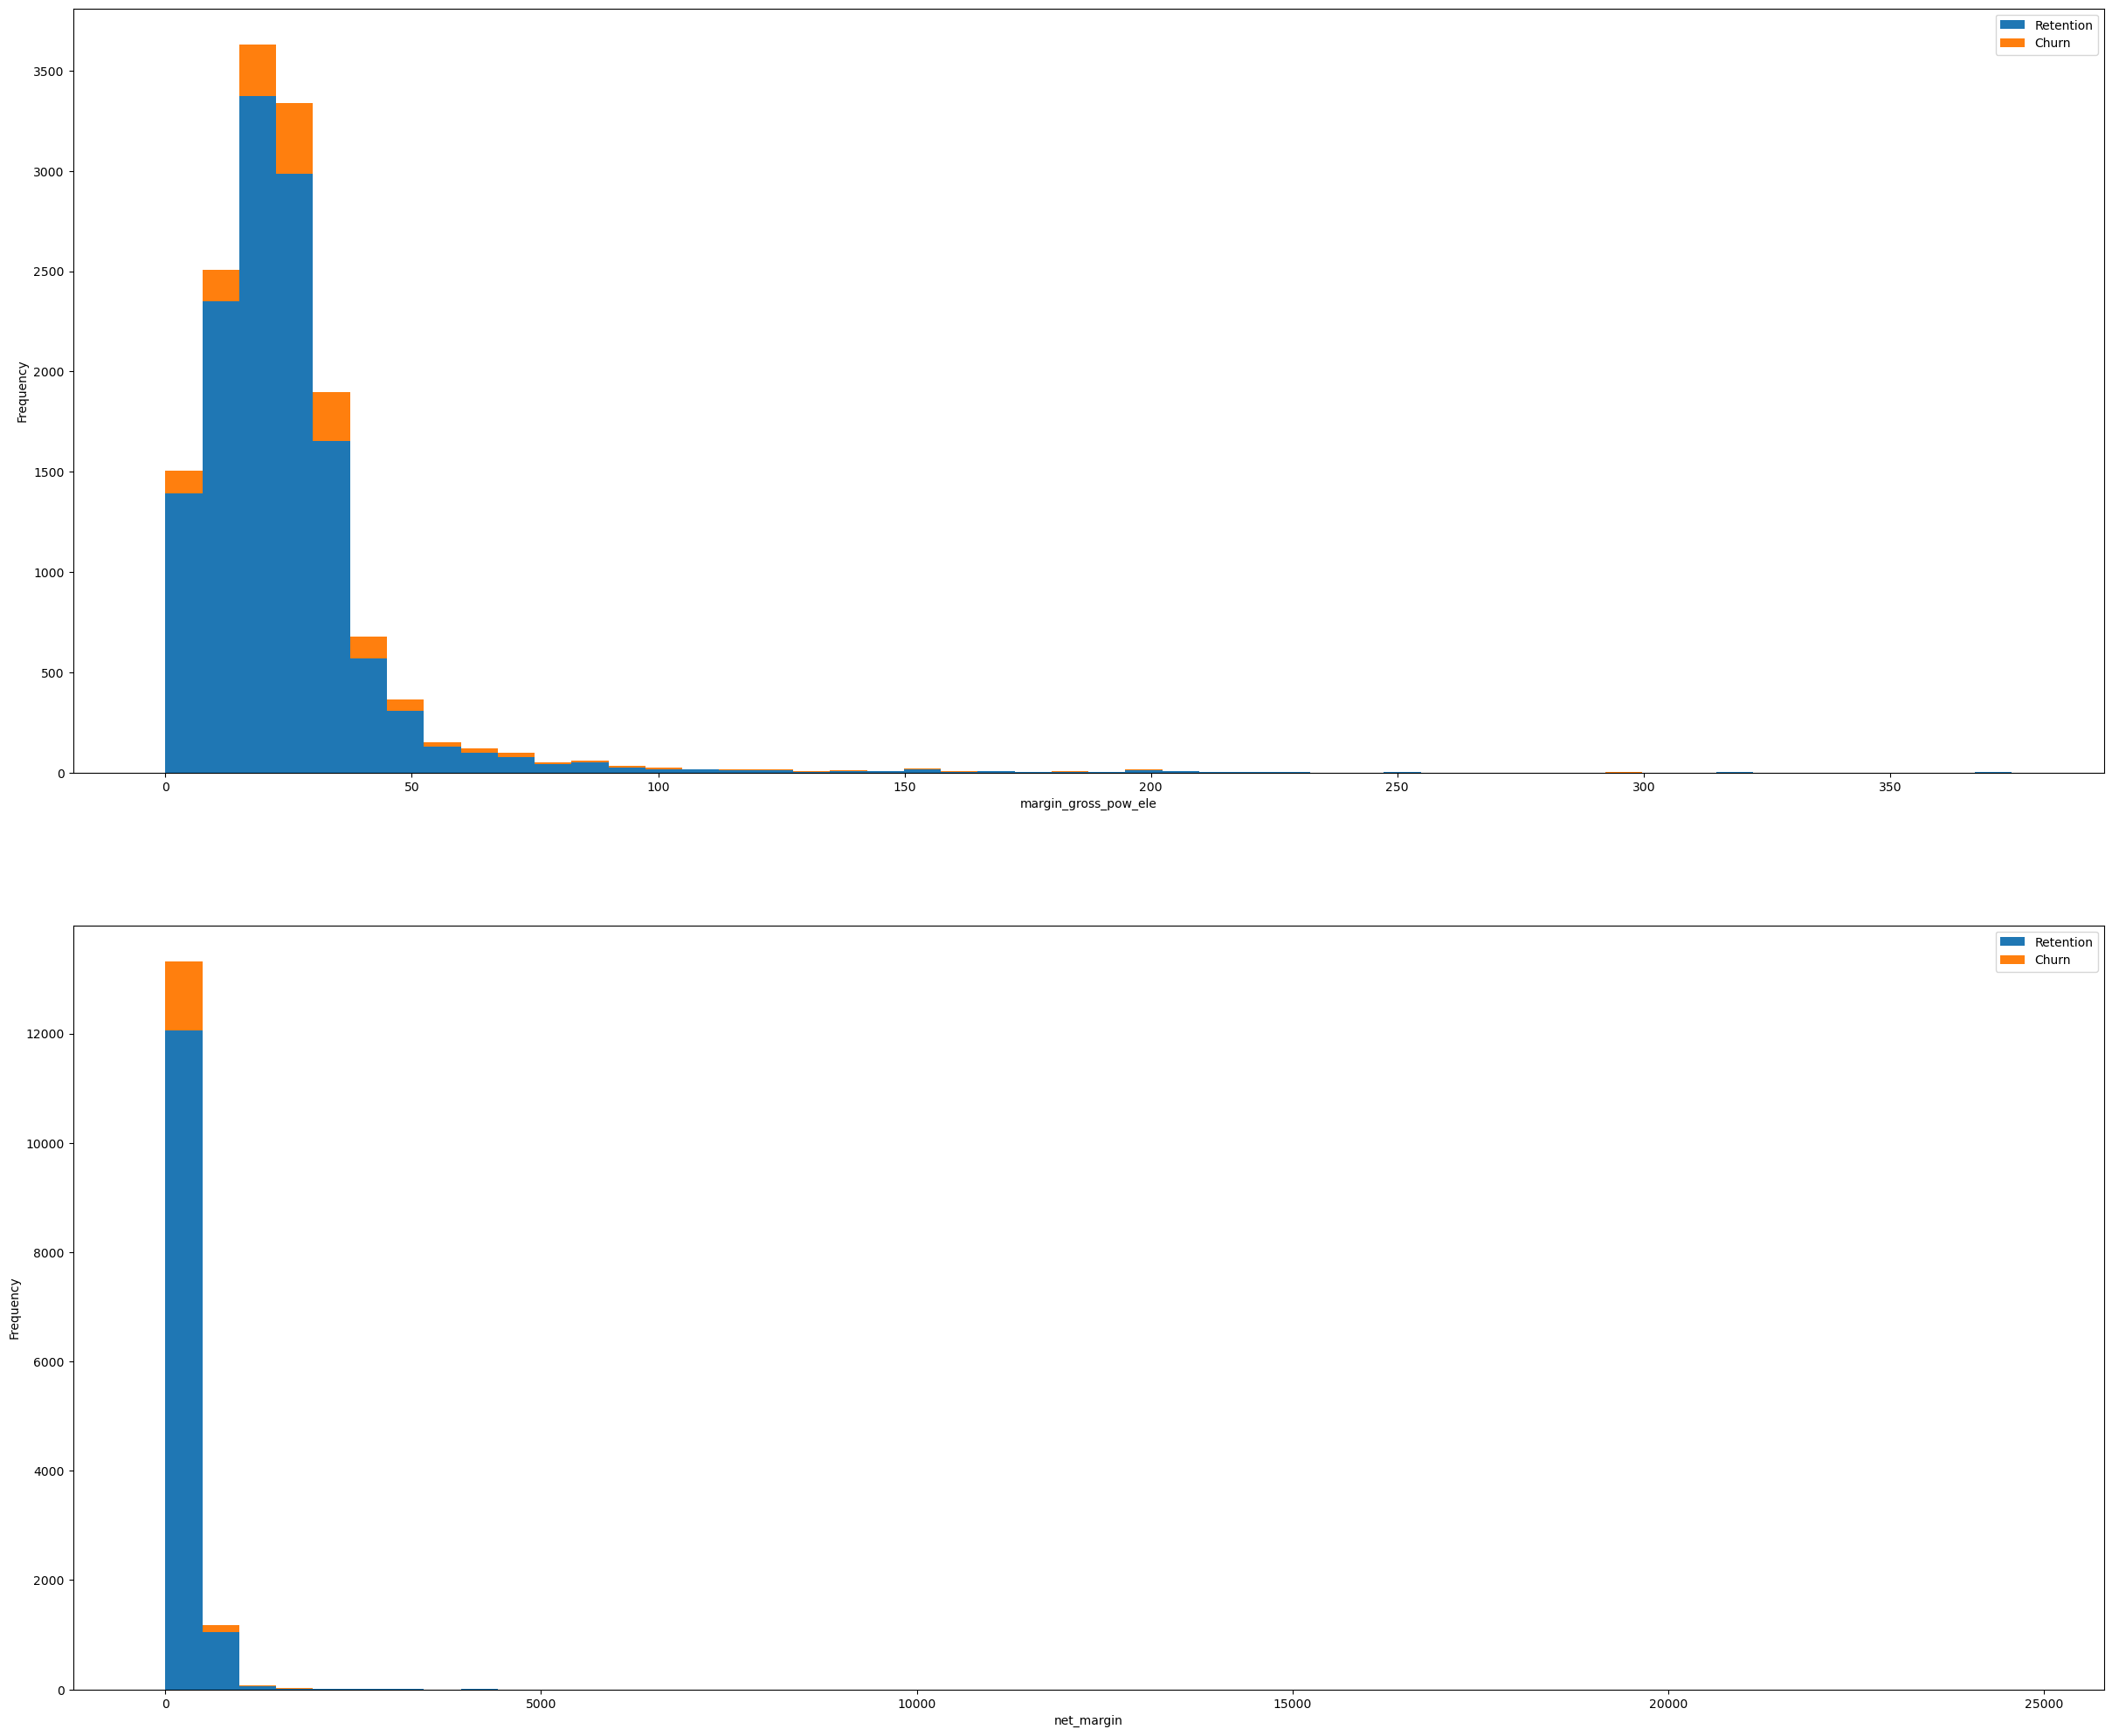

In [34]:
fig, axs = plt.subplots(nrows=2, figsize=(30, 25))

plot_distribution(df, 'margin_gross_pow_ele', axs[0])
plot_distribution(df, 'net_margin', axs[1])
plt.show()

Logically, net margin should be lower than gross margin but here net margin is higher. It maybe due to the fact that we have gross margin only for power subscription.

In [35]:
df.groupby('origin_up').sum()['churn'].sort_values(ascending = False)/df.loc[df['churn'] == 1].shape[0]

origin_up
lxidpiddsbxsbosboudacockeimpuepw    0.629316
ldkssxwpmemidmecebumciepifcamkci    0.186047
kamkkxfxxuwbdslkwifmmcsiusiuosws    0.181818
MISSING                             0.002819
ewxeelcelemmiwuafmddpobolfuxioce    0.000000
usapbepcfoloekilkwsdiboslwaxobdp    0.000000
Name: churn, dtype: float64

In [36]:
df.loc[df['churn'] == 0].groupby('origin_up').count()['id'].sort_values(ascending = False)/df.loc[df['churn'] == 0].shape[0]

origin_up
lxidpiddsbxsbosboudacockeimpuepw    0.470463
kamkkxfxxuwbdslkwifmmcsiusiuosws    0.306059
ldkssxwpmemidmecebumciepifcamkci    0.218700
MISSING                             0.004550
usapbepcfoloekilkwsdiboslwaxobdp    0.000152
ewxeelcelemmiwuafmddpobolfuxioce    0.000076
Name: id, dtype: float64

This shows us that proportion of customers churning across the origin program varies. If it does not vary then propertion of churn vs not churn should have been same for the groups. But we can clearly observe that lxi Electricity Campaign has higher proportion of churn than other groups relatively.

In [37]:
df.groupby('channel_sales').sum()['churn'].sort_values(ascending = False)/df.loc[df['churn'] == 1].shape[0]

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    0.577872
MISSING                             0.199436
usilxuppasemubllopkaafesmlibmsdf    0.097252
lmkebamcaaclubfxadlmueccxoimlema    0.072586
ewpakwlliwisiwduibdlfmalxowmwpci    0.052854
epumfxlbckeskwekxbiuasklxalciiuu    0.000000
fixdbufsefwooaasfcxdxadsiekoceaa    0.000000
sddiedcslfslkckwlfkdpoeeailfpeds    0.000000
Name: churn, dtype: float64

In [38]:
df.loc[df['churn'] == 0].groupby('channel_sales').count()['id'].sort_values(ascending = False)/df.loc[df['churn'] == 0].shape[0]

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    0.449989
MISSING                             0.261015
lmkebamcaaclubfxadlmueccxoimlema    0.131948
usilxuppasemubllopkaafesmlibmsdf    0.093805
ewpakwlliwisiwduibdlfmalxowmwpci    0.062031
sddiedcslfslkckwlfkdpoeeailfpeds    0.000834
epumfxlbckeskwekxbiuasklxalciiuu    0.000227
fixdbufsefwooaasfcxdxadsiekoceaa    0.000152
Name: id, dtype: float64

In [39]:
print(df.groupby('channel_sales')['churn'].value_counts(normalize = True))

channel_sales                     churn
MISSING                           0        0.924027
                                  1        0.075973
epumfxlbckeskwekxbiuasklxalciiuu  0        1.000000
ewpakwlliwisiwduibdlfmalxowmwpci  0        0.916013
                                  1        0.083987
fixdbufsefwooaasfcxdxadsiekoceaa  0        1.000000
foosdfpfkusacimwkcsosbicdxkicaua  0        0.878590
                                  1        0.121410
lmkebamcaaclubfxadlmueccxoimlema  0        0.944113
                                  1        0.055887
sddiedcslfslkckwlfkdpoeeailfpeds  0        1.000000
usilxuppasemubllopkaafesmlibmsdf  0        0.899636
                                  1        0.100364
Name: proportion, dtype: float64


In [40]:
#Analyzing the breakup more in depth
print(df.groupby('origin_up')['churn'].value_counts(normalize = True))
print(df.groupby(['channel_sales','origin_up']).agg({'churn':'mean'}))

origin_up                         churn
MISSING                           0        0.937500
                                  1        0.062500
ewxeelcelemmiwuafmddpobolfuxioce  0        1.000000
kamkkxfxxuwbdslkwifmmcsiusiuosws  0        0.939916
                                  1        0.060084
ldkssxwpmemidmecebumciepifcamkci  0        0.916137
                                  1        0.083863
lxidpiddsbxsbosboudacockeimpuepw  0        0.874172
                                  1        0.125828
usapbepcfoloekilkwsdiboslwaxobdp  0        1.000000
Name: proportion, dtype: float64
                                                                      churn
channel_sales                    origin_up                                 
MISSING                          MISSING                           0.000000
                                 ewxeelcelemmiwuafmddpobolfuxioce  0.000000
                                 kamkkxfxxuwbdslkwifmmcsiusiuosws  0.065330
                           

For the sales channels and campaigns, proportion of customers is similar to the churn customers proportion but for some groups churn rate is quite higher. For electricity campaigns we can observe that lxidpi has 12.6% churn rate which is quite higher than 9.72% churn rate generally. And for sales channel its 12.12% for foosdf channel. Overall, some sales channel and campaigns witnessed more than average customer churn rate.

And combining both of them in subgroups we can see that there are many subgroups with more than 12% churn rate with highest being at 14.3% churn rate which is 47% higher than average churn rate. All this is a metter of concerns and imply that churn rate varies a lot across different sales channel and promotion campaigns. 

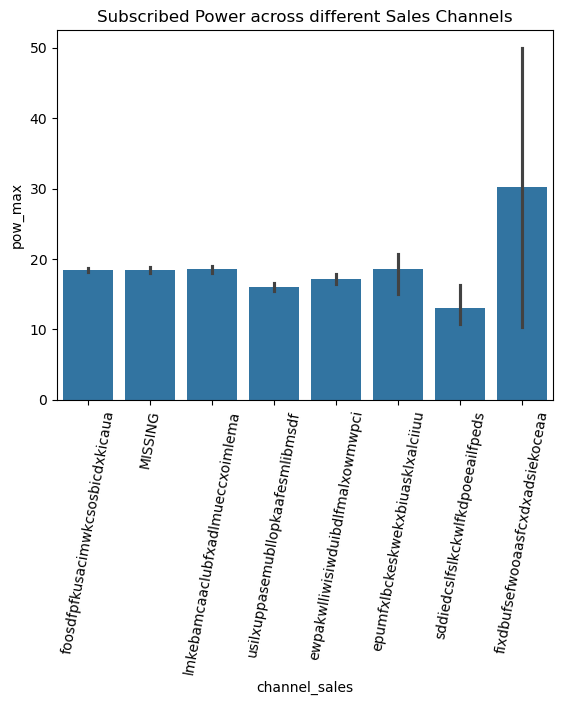

In [41]:
sns.barplot(data = df, x = 'channel_sales', y = 'pow_max')
plt.xticks(rotation = 80)
plt.title('Subscribed Power across different Sales Channels')
plt.show()

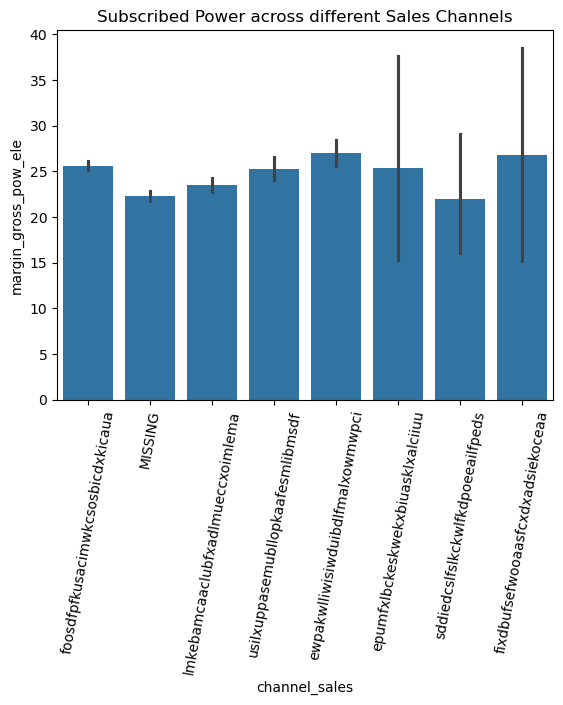

In [42]:
sns.barplot(data = df, x = 'channel_sales', y = 'margin_gross_pow_ele')
plt.xticks(rotation = 80)
plt.title('Subscribed Power across different Sales Channels')
plt.show()

In [43]:
#Analyzing antiquity of the clients
df['num_years_antig'].describe()

count    14606.000000
mean         4.997809
std          1.611749
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         13.000000
Name: num_years_antig, dtype: float64

In [44]:
df.groupby('channel_sales').count()['num_years_antig']

channel_sales
MISSING                             3725
epumfxlbckeskwekxbiuasklxalciiuu       3
ewpakwlliwisiwduibdlfmalxowmwpci     893
fixdbufsefwooaasfcxdxadsiekoceaa       2
foosdfpfkusacimwkcsosbicdxkicaua    6754
lmkebamcaaclubfxadlmueccxoimlema    1843
sddiedcslfslkckwlfkdpoeeailfpeds      11
usilxuppasemubllopkaafesmlibmsdf    1375
Name: num_years_antig, dtype: int64

In [45]:
temp_df = pd.merge(df.groupby('channel_sales').sum()['churn'].reset_index(),df.groupby('channel_sales')[['num_years_antig']].mean().reset_index(), on = 'channel_sales', how = 'inner')

temp_df.columns = ['channel_sales', 'churn', 'mean_years_antig']
temp_df

,channel_sales,churn,mean_years_antig
0,MISSING,283,6.492617
1,epumfxlbckeskwekxbiuasklxalciiuu,0,3.000000
2,ewpakwlliwisiwduibdlfmalxowmwpci,75,4.272116
3,fixdbufsefwooaasfcxdxadsiekoceaa,0,3.000000
4,foosdfpfkusacimwkcsosbicdxkicaua,820,4.414125
5,lmkebamcaaclubfxadlmueccxoimlema,103,5.196419
6,sddiedcslfslkckwlfkdpoeeailfpeds,0,3.000000
7,usilxuppasemubllopkaafesmlibmsdf,138,4.043636


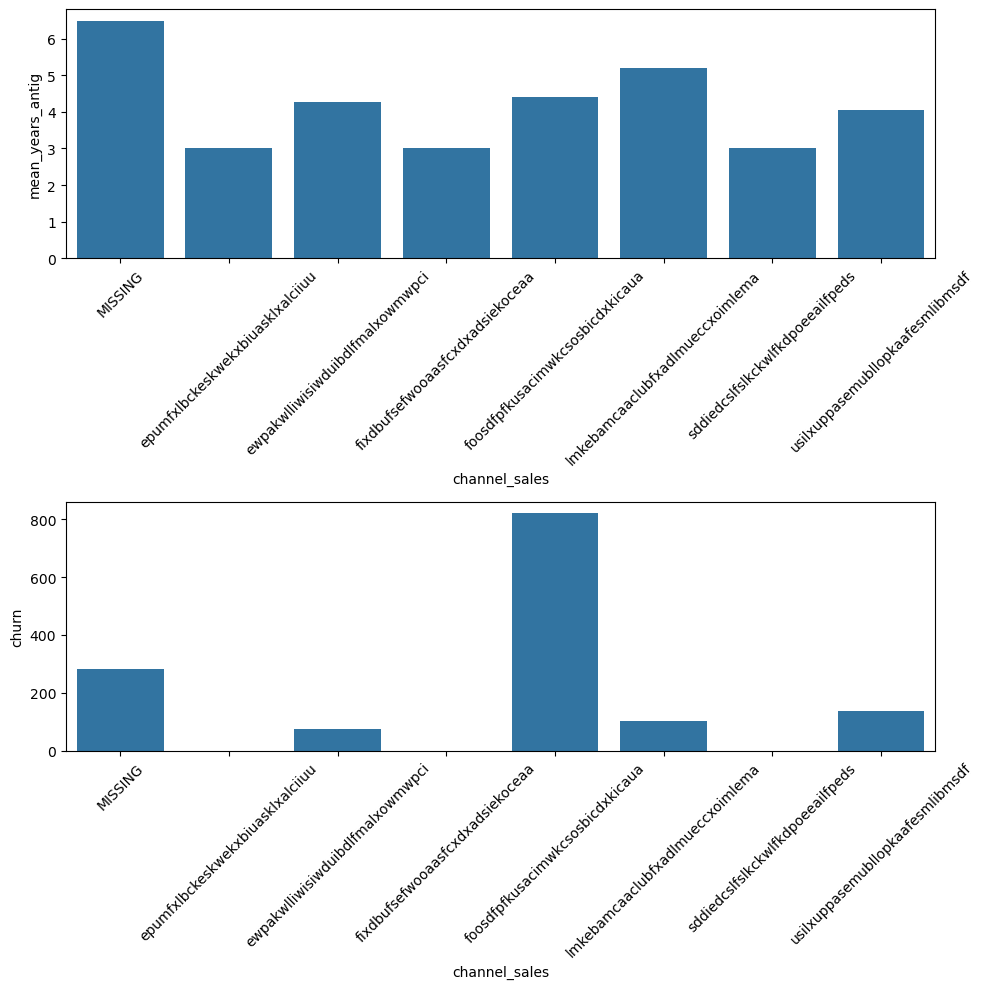

In [46]:
fig, ax = plt.subplots(nrows = 2, figsize = (10,10))

sns.barplot(temp_df, x = 'channel_sales', y = 'mean_years_antig', ax = ax[0])
sns.barplot(temp_df, x = 'channel_sales', y = 'churn', ax = ax[1])
for ax in ax:
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

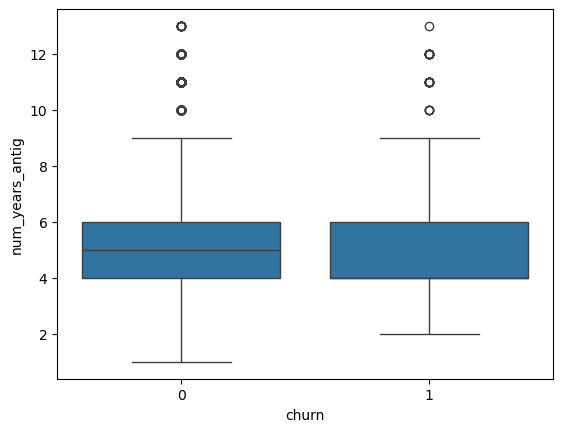

In [47]:
sns.boxplot(df, x = 'churn', y = 'num_years_antig')
plt.show()

Overall, customers churned has mean of atinquity is around 4 years. While distribution of churn and retention for customers is quite similar when we look across different sales channel it presents a different story.

We can observe churns happening in sales channels having antiquity more than the mean of 4 years. While the churn rate appears normal for all groups, 'foosdfpfkusacimwkcsosbicdxkicaua' sales group has a higher amount of churns than others. Yes, it has more customers too but even then it should have been 500-600 churns instead of 820 churns. This implies that this sales group witnessed higher than normal churn rate for PowerCo.

In [48]:
df.filter(regex = 'var_').corr()

,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak
var_year_price_off_peak_var,1.000000,0.268477,0.245311,0.515049,0.227269,0.229893,0.515064,0.227272,0.229894,0.619343,0.265968,0.269555,0.441878,0.264435,0.264312,0.441880,0.264437,0.264313
var_year_price_peak_var,0.268477,1.000000,0.515645,0.298254,0.451123,0.475760,0.298256,0.451135,0.475761,0.295638,0.647083,0.312539,0.278371,0.279135,0.283905,0.278372,0.279144,0.283906
var_year_price_mid_peak_var,0.245311,0.515645,1.000000,0.296689,0.948578,0.961481,0.296691,0.948579,0.961483,0.301787,0.292145,0.666421,0.276626,0.637463,0.638773,0.276627,0.637464,0.638774
var_year_price_off_peak_fix,0.515049,0.298254,0.296689,1.000000,0.340722,0.310471,1.000000,0.340724,0.310471,0.755875,0.425467,0.420256,0.919000,0.460190,0.426243,0.919000,0.460194,0.426243
var_year_price_peak_fix,0.227269,0.451123,0.948578,0.340722,1.000000,0.954353,0.340723,1.000000,0.954354,0.309477,0.273434,0.649140,0.310610,0.662291,0.637355,0.310611,0.662291,0.637355
var_year_price_mid_peak_fix,0.229893,0.475760,0.961481,0.310471,0.954353,1.000000,0.310472,0.954354,1.000000,0.310865,0.283188,0.664660,0.290756,0.650680,0.670265,0.290757,0.650680,0.670265
var_year_price_off_peak,0.515064,0.298256,0.296691,1.000000,0.340723,0.310472,1.000000,0.340725,0.310472,0.755879,0.425468,0.420257,0.918999,0.460191,0.426243,0.918999,0.460195,0.426244
var_year_price_peak,0.227272,0.451135,0.948579,0.340724,1.000000,0.954354,0.340725,1.000000,0.954355,0.309480,0.273442,0.649141,0.310612,0.662291,0.637355,0.310613,0.662291,0.637355
var_year_price_mid_peak,0.229894,0.475761,0.961483,0.310471,0.954354,1.000000,0.310472,0.954355,1.000000,0.310865,0.283188,0.664661,0.290756,0.650680,0.670265,0.290757,0.650681,0.670265
var_6m_price_off_peak_var,0.619343,0.295638,0.301787,0.755875,0.309477,0.310865,0.755879,0.309480,0.310865,1.000000,0.468700,0.475458,0.813497,0.480090,0.473619,0.813501,0.480094,0.473620


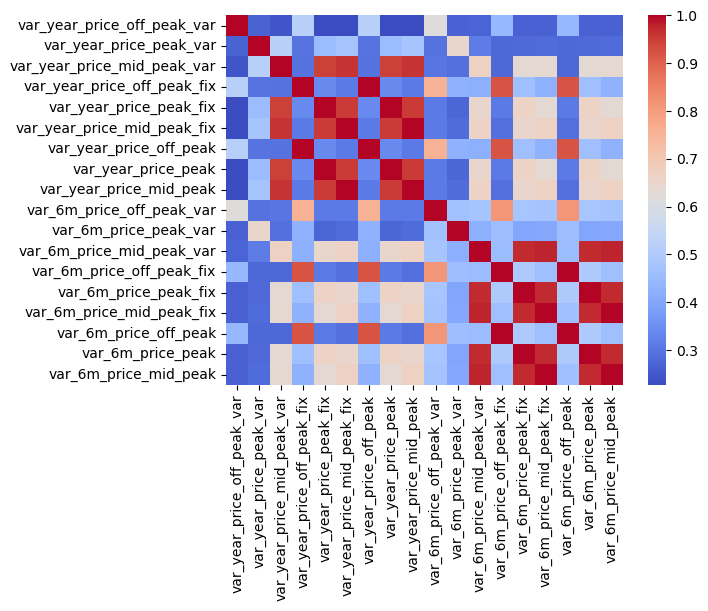

In [49]:
sns.heatmap(df.filter(regex = 'var').corr(), cmap = 'coolwarm')
plt.show()

These are the columns added by BCGX team, we can observe high correlations across many of the columns. While we can remove some of them, for prediction we will use decision trees and neurel networks so this will not impact a lot.

In [50]:
df.groupby('churn').sum()[['imp_cons']]

,imp_cons
churn,
0,2017138.69
1,214466.71


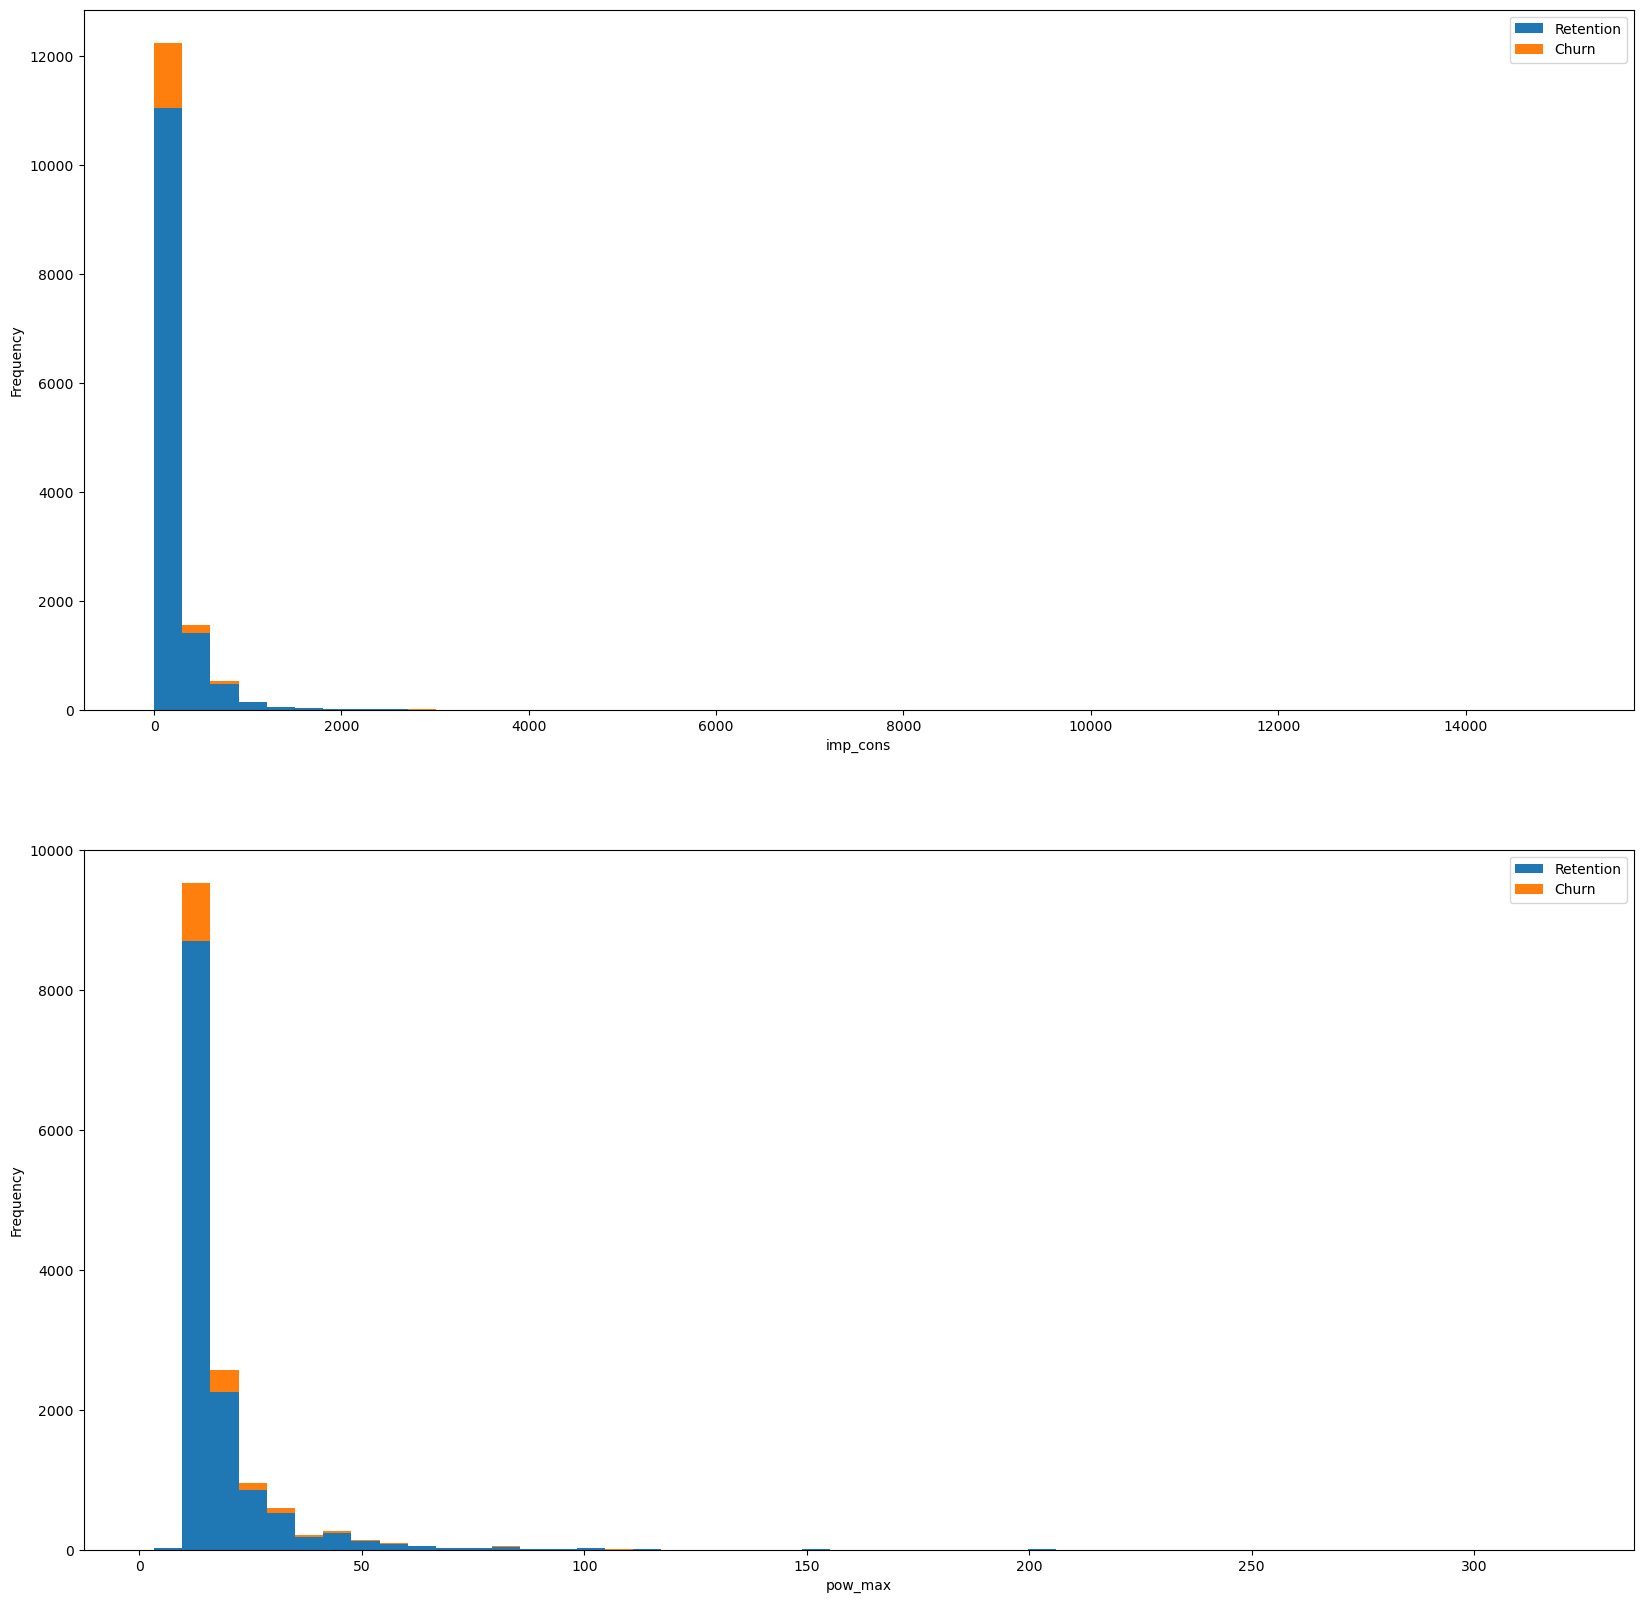

In [51]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

plot_distribution(df, 'imp_cons', axs[0])
plot_distribution(df, 'pow_max', axs[1])
plt.show()

In [52]:
df.groupby('origin_up').sum()['churn']

origin_up
MISSING                               4
ewxeelcelemmiwuafmddpobolfuxioce      0
kamkkxfxxuwbdslkwifmmcsiusiuosws    258
ldkssxwpmemidmecebumciepifcamkci    264
lxidpiddsbxsbosboudacockeimpuepw    893
usapbepcfoloekilkwsdiboslwaxobdp      0
Name: churn, dtype: int64

### Price Dataset EDA

In [53]:
#Loading price data
df_price = pd.read_csv('price_data.csv')
df_price['price_date'] = pd.to_datetime(df_price['price_date'])
df_price['price_month'] = df_price['price_date'].dt.month #Converting date column and extracting month
df_price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_month
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,1
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,2
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,3
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,4
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,5


In [54]:
#extracting meaningful insights from date

df_price['is_weekend'] = df_price['price_date'].dt.dayofweek >= 5 #Weekend price is generally more than weekdays
df_price['is_month_start'] = df_price['price_date'].dt.is_month_start #Month start price
df_price['is_month_end'] = df_price['price_date'].dt.is_month_end #Month end price
df_price['quarter'] = df_price['price_date'].dt.quarter #Quaterly price

In [55]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
 8   price_month         193002 non-null  int32         
 9   is_weekend          193002 non-null  bool          
 10  is_month_start      193002 non-null  bool          
 11  is_month_end        193002 non-null  bool          
 12  quarter             193002 non-null  int32         
dtypes: bool(3), datetime64[ns](1)

In [56]:
#More feature engineering on price variables. We are covering price differences, average prices, and weekend prices

df_price['var_peak_offpeak_spread'] = df_price['price_peak_var'] - df_price['price_off_peak_var']
df_price['fix_peak_offpeak_spread'] = df_price['price_peak_fix'] - df_price['price_off_peak_fix']
df_price['avg_var_price'] = df_price[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']].mean(axis=1)
df_price['avg_fix_price'] = df_price[['price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].mean(axis=1)
df_price['peak_var_x_is_weekend'] = df_price['price_peak_var'] * df_price['is_weekend'].astype(int)

In [57]:
df_price.corr(numeric_only = True)

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_month,is_weekend,is_month_start,is_month_end,quarter,var_peak_offpeak_spread,fix_peak_offpeak_spread,avg_var_price,avg_fix_price,peak_var_x_is_weekend
price_off_peak_var,1.000000,-0.328580,-0.594872,0.417097,-0.630018,-0.572229,-0.083796,-0.016939,NaN,NaN,-0.081647,-0.660111,-0.742420,-0.174635,-0.502655,-0.155150
price_peak_var,-0.328580,1.000000,0.821353,-0.098627,0.796097,0.807759,-0.012409,-0.003991,NaN,NaN,-0.011674,0.926359,0.771820,0.963302,0.780654,0.427270
price_mid_peak_var,-0.594872,0.821353,1.000000,-0.137848,0.973960,0.979717,0.003895,0.001135,NaN,NaN,0.004327,0.890470,0.950930,0.840718,0.947287,0.355659
price_off_peak_fix,0.417097,-0.098627,-0.137848,1.000000,-0.000428,-0.252661,0.013119,-0.001878,NaN,NaN,0.012386,-0.244772,-0.388586,0.006916,0.168202,-0.044383
price_peak_fix,-0.630018,0.796097,0.973960,-0.000428,1.000000,0.927308,-0.000862,0.001788,NaN,NaN,-0.000344,0.884398,0.921579,0.799150,0.980064,0.345639
price_mid_peak_fix,-0.572229,0.807759,0.979717,-0.252661,0.927308,1.000000,-0.001079,0.002100,NaN,NaN,-0.000579,0.870628,0.952514,0.829294,0.895341,0.350978
price_month,-0.083796,-0.012409,0.003895,0.013119,-0.000862,-0.001079,1.000000,-0.102431,NaN,NaN,0.971625,0.023547,-0.005887,-0.034696,0.002519,-0.074579
is_weekend,-0.016939,-0.003991,0.001135,-0.001878,0.001788,0.002100,-0.102431,1.000000,NaN,NaN,-0.158085,0.003581,0.002377,-0.007841,0.001424,0.665309
is_month_start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_month_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As expected correlation is high for various columns. While multicollinearity is a negative aspect for a dataset decision trees, especially boosting techniques can counter it alongside Neurel Network approaches.

In [58]:
df_price['price_month']

0          1
1          2
2          3
3          4
4          5
          ..
192997     8
192998     9
192999    10
193000    11
193001    12
Name: price_month, Length: 193002, dtype: int32

In [59]:
df_price[['price_peak_var', 'price_month']].groupby('price_month').agg({'price_peak_var':'mean'})

,price_peak_var
price_month,
1,0.054950
2,0.055053
3,0.055118
4,0.056035
5,0.055359
6,0.055255
7,0.055369
8,0.053605
9,0.053532


In [60]:
df_price[['price_peak_fix', 'price_month']].groupby('price_month').agg({'price_peak_fix':'mean'})

,price_peak_fix
price_month,
1,10.692921
2,10.673719
3,10.644489
4,10.647277
5,10.602453
6,10.415769
7,10.642236
8,10.661678
9,10.602979


Average peak price for Energy and Power is quite similar across the different months for an year. Overall prices are not varying much across the year.

In [61]:
#Checking null values
print(df_price.isnull().sum())

id                         0
price_date                 0
price_off_peak_var         0
price_peak_var             0
price_mid_peak_var         0
price_off_peak_fix         0
price_peak_fix             0
price_mid_peak_fix         0
price_month                0
is_weekend                 0
is_month_start             0
is_month_end               0
quarter                    0
var_peak_offpeak_spread    0
fix_peak_offpeak_spread    0
avg_var_price              0
avg_fix_price              0
peak_var_x_is_weekend      0
dtype: int64


In [62]:
print(df_price.describe())

                          price_date  price_off_peak_var  price_peak_var  \
count                         193002       193002.000000   193002.000000   
mean   2015-06-16 12:50:49.933161216            0.141027        0.054630   
min              2015-01-01 00:00:00            0.000000        0.000000   
25%              2015-04-01 00:00:00            0.125976        0.000000   
50%              2015-07-01 00:00:00            0.146033        0.085483   
75%              2015-10-01 00:00:00            0.151635        0.101673   
max              2015-12-01 00:00:00            0.280700        0.229788   
std                              NaN            0.025032        0.049924   

       price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
count       193002.000000       193002.000000   193002.000000   
mean             0.030496           43.334477       10.622875   
min              0.000000            0.000000        0.000000   
25%              0.000000           40.728885        0.

In [63]:
print(df_price[['is_weekend', 'is_month_start', 'is_month_end']].sum())
print(df_price['quarter'].value_counts())

is_weekend         64337
is_month_start    193002
is_month_end           0
dtype: int64
quarter
4    48266
3    48266
2    48244
1    48226
Name: count, dtype: int64


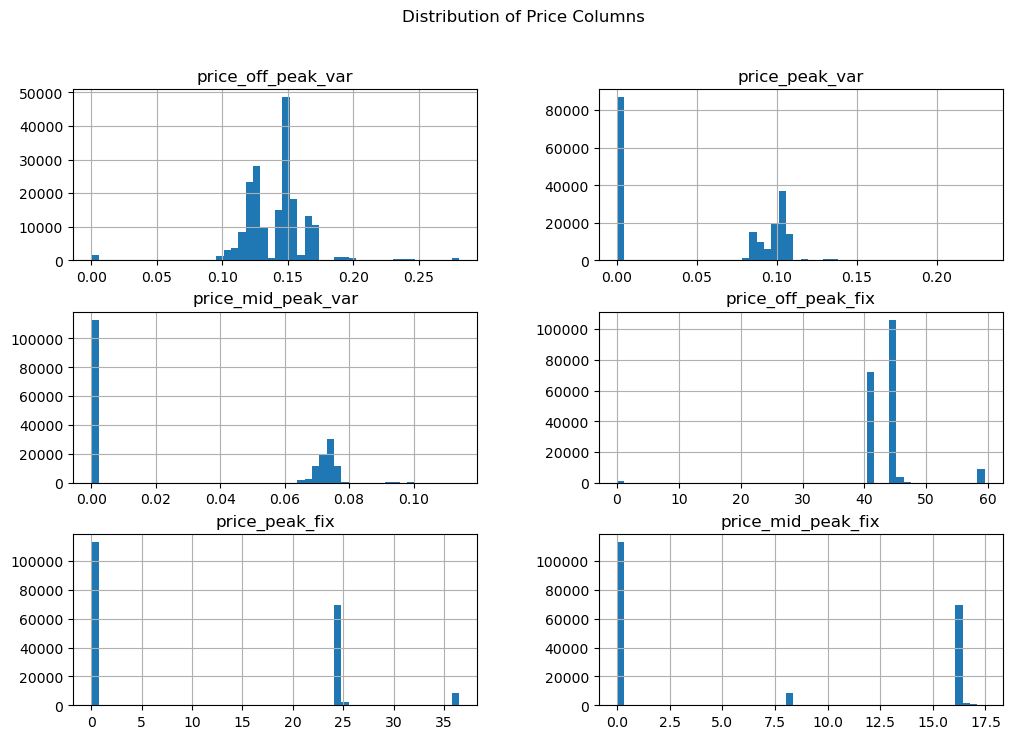

In [64]:
df_price[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].hist(bins=50, figsize=(12,8))
plt.suptitle('Distribution of Price Columns')
plt.show()

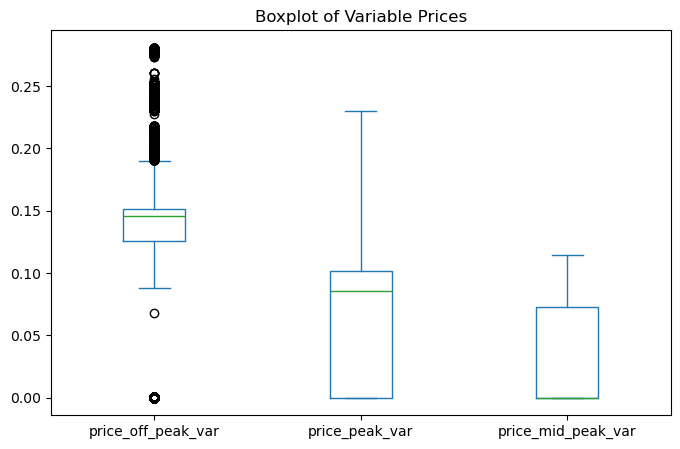

In [65]:
df_price[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']].plot(kind='box', figsize=(8,5))
plt.title('Boxplot of Variable Prices')
plt.show()

There are a lot of outliers in off peak vs other categories. And again we are seeing peak pricing less than off peak when in reality it happens in inverse, most probably BCGX team adjusted the variables for the sake of anonymity of their client. Regardless of name of variables we can use the data for our predictive tasks.

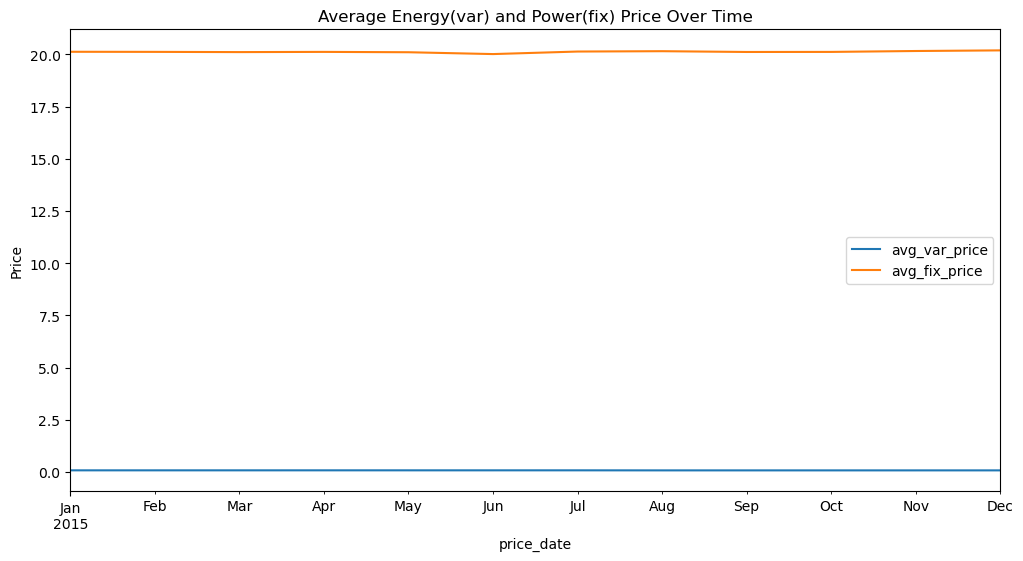

In [66]:
daily_avg = df_price.groupby('price_date')[['avg_var_price', 'avg_fix_price']].mean()
daily_avg.plot(figsize=(12,6), title='Average Energy(var) and Power(fix) Price Over Time')
plt.ylabel('Price')
plt.show()

In [67]:
#Average price for energy and power does not change much across the year
daily_avg.head()

,avg_var_price,avg_fix_price
price_date,,
2015-01-01,0.075950,20.125141
2015-02-01,0.076063,20.120299
2015-03-01,0.076206,20.109548
2015-04-01,0.076595,20.119624
2015-05-01,0.076429,20.102882


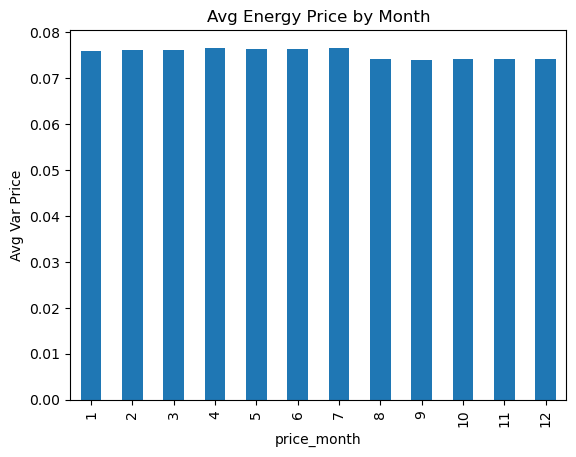

In [68]:
df_price.groupby('price_month')['avg_var_price'].mean().plot(kind='bar', title='Avg Energy Price by Month')
plt.ylabel('Avg Var Price')
plt.show()

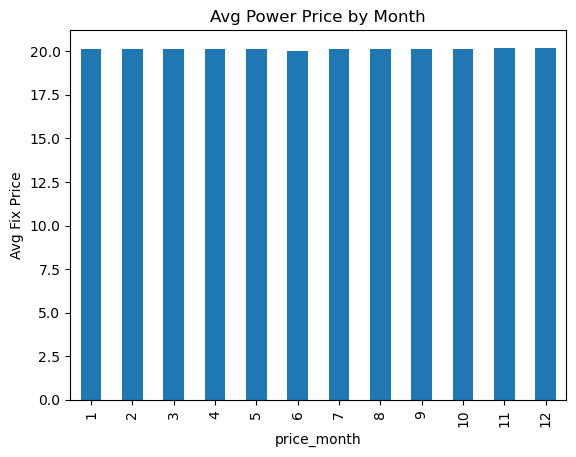

In [69]:
df_price.groupby('price_month')['avg_fix_price'].mean().plot(kind='bar', title='Avg Power Price by Month')
plt.ylabel('Avg Fix Price')
plt.show()

Average price for both energy and power connections are not varying much, client PowerCo has very stable pricing for the period.

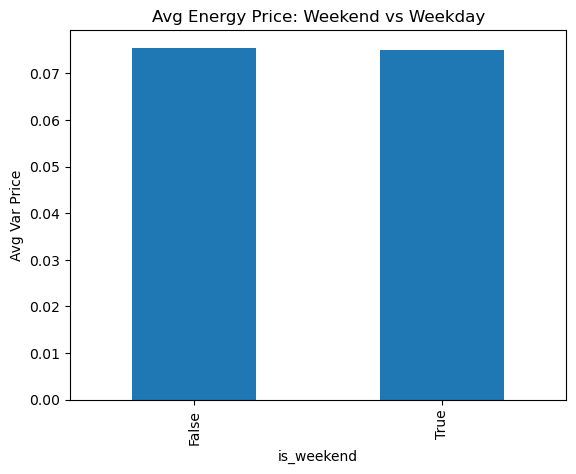

In [70]:
df_price.groupby('is_weekend')['avg_var_price'].mean().plot(kind='bar', title='Avg Energy Price: Weekend vs Weekday')
plt.ylabel('Avg Var Price')
plt.show()

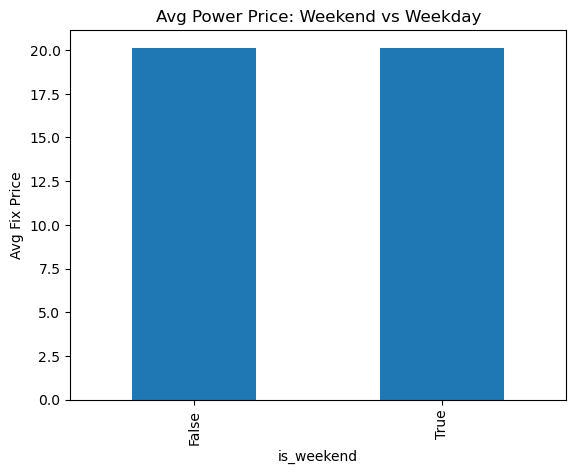

In [71]:
df_price.groupby('is_weekend')['avg_fix_price'].mean().plot(kind='bar', title='Avg Power Price: Weekend vs Weekday')
plt.ylabel('Avg Fix Price')
plt.show()

In [72]:
print(df_price.groupby('is_weekend')['avg_var_price'].mean())

is_weekend
False    0.075522
True     0.075110
Name: avg_var_price, dtype: float64


In [73]:
print(df_price.groupby('is_weekend')['avg_fix_price'].mean())

is_weekend
False    20.115581
True     20.136173
Name: avg_fix_price, dtype: float64


Overall for the weekends price is not varying much in both energy and power connections.

----
## Model Training, Hyperparameter Tuning, and Evaluation

In this step we will cover model training, hyperparameter tuning, and evaluation for three types of models: XGBoost Ensemble Method based on Decision Trees, Dense Neural Network based on Dense Layers, and BiDirectional LSTM-CNN model which combines LSTM and CNN layers for Churn Prediction.

While XGBoost works fine with or without Scaled Paramteres we will scale the dataset for training as other two models need data scaling. For hyperparameter tuning we will focus on Gradient Boosting and BiLSTM - CNN. For the DNN Model hyperparameter we already tested some combinations in advance and used both regularization with early stopping.

We will evaluate the models on the basis of ROC-AUC Score, F1 Score, Recall, and Accuracy with less focus on Accuracy as ROC-AUC and Recall scores are better predictor for this task.

### Data Preperation

In this step we will prepare data for modeling.

In [74]:
#Merging price and client data with left join on price 
df_price.drop(columns = 'price_date', inplace = True)
df_merge = df_price.merge(df, on = 'id', how = 'left')
df_merge.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_month,is_weekend,is_month_start,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,tenure,end_month
0,038af19179925da21a25619c5a24b745,0.151367,0.0,0.0,44.266931,0.0,0.0,1,False,True,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,1096.0,6.0
1,038af19179925da21a25619c5a24b745,0.151367,0.0,0.0,44.266931,0.0,0.0,2,True,True,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,1096.0,6.0
2,038af19179925da21a25619c5a24b745,0.151367,0.0,0.0,44.266931,0.0,0.0,3,True,True,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,1096.0,6.0
3,038af19179925da21a25619c5a24b745,0.149626,0.0,0.0,44.266931,0.0,0.0,4,False,True,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,1096.0,6.0
4,038af19179925da21a25619c5a24b745,0.149626,0.0,0.0,44.266931,0.0,0.0,5,False,True,...,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0,1096.0,6.0


BCGX standard answer did left merge on the client dataset but for this task left merge on price data is an industry norm because it helps us to capture more day to day data representations in the model and predictions. 

In [75]:
df_merge.info

<bound method DataFrame.info of                                       id  price_off_peak_var  price_peak_var  \
0       038af19179925da21a25619c5a24b745            0.151367        0.000000   
1       038af19179925da21a25619c5a24b745            0.151367        0.000000   
2       038af19179925da21a25619c5a24b745            0.151367        0.000000   
3       038af19179925da21a25619c5a24b745            0.149626        0.000000   
4       038af19179925da21a25619c5a24b745            0.149626        0.000000   
...                                  ...                 ...             ...   
192997  16f51cdc2baa19af0b940ee1b3dd17d5            0.119916        0.102232   
192998  16f51cdc2baa19af0b940ee1b3dd17d5            0.119916        0.102232   
192999  16f51cdc2baa19af0b940ee1b3dd17d5            0.119916        0.102232   
193000  16f51cdc2baa19af0b940ee1b3dd17d5            0.119916        0.102232   
193001  16f51cdc2baa19af0b940ee1b3dd17d5            0.119916        0.102232   

       

In [76]:
#Checking na values
df_merge.isna().sum()

id                                    0
price_off_peak_var                    0
price_peak_var                        0
price_mid_peak_var                    0
price_off_peak_fix                    0
price_peak_fix                        0
price_mid_peak_fix                    0
price_month                           0
is_weekend                            0
is_month_start                        0
is_month_end                          0
quarter                               0
var_peak_offpeak_spread               0
fix_peak_offpeak_spread               0
avg_var_price                         0
avg_fix_price                         0
peak_var_x_is_weekend                 0
channel_sales                     17853
cons_12m                          17853
cons_gas_12m                      17853
cons_last_month                   17853
forecast_cons_12m                 17853
forecast_discount_energy          17853
forecast_meter_rent_12m           17853
forecast_price_energy_off_peak    17853


In [77]:
missing_ids = set(df_price['id']) - set(df['id'])
print(f"Number of unmatched client ids: {len(missing_ids)}")

Number of unmatched client ids: 1490


In [78]:
#Since Price dataset has more client ids than client df iteself we will only cover data for client ids fallinf under sales channels
df_merge = df_merge[df_merge['channel_sales'].notnull()]

In [79]:
df_merge.isna().sum()

id                                0
price_off_peak_var                0
price_peak_var                    0
price_mid_peak_var                0
price_off_peak_fix                0
price_peak_fix                    0
price_mid_peak_fix                0
price_month                       0
is_weekend                        0
is_month_start                    0
is_month_end                      0
quarter                           0
var_peak_offpeak_spread           0
fix_peak_offpeak_spread           0
avg_var_price                     0
avg_fix_price                     0
peak_var_x_is_weekend             0
channel_sales                     0
cons_12m                          0
cons_gas_12m                      0
cons_last_month                   0
forecast_cons_12m                 0
forecast_discount_energy          0
forecast_meter_rent_12m           0
forecast_price_energy_off_peak    0
forecast_price_energy_peak        0
forecast_price_pow_off_peak       0
has_gas                     

In [80]:
df_merge.select_dtypes(include = ['object', 'category']).head()

,id,channel_sales,origin_up
0,038af19179925da21a25619c5a24b745,foosdfpfkusacimwkcsosbicdxkicaua,ldkssxwpmemidmecebumciepifcamkci
1,038af19179925da21a25619c5a24b745,foosdfpfkusacimwkcsosbicdxkicaua,ldkssxwpmemidmecebumciepifcamkci
2,038af19179925da21a25619c5a24b745,foosdfpfkusacimwkcsosbicdxkicaua,ldkssxwpmemidmecebumciepifcamkci
3,038af19179925da21a25619c5a24b745,foosdfpfkusacimwkcsosbicdxkicaua,ldkssxwpmemidmecebumciepifcamkci
4,038af19179925da21a25619c5a24b745,foosdfpfkusacimwkcsosbicdxkicaua,ldkssxwpmemidmecebumciepifcamkci


Now we will remove id variables. For channel_sales and origin_up we will use one hot encoding.

In [81]:
df_merge = pd.get_dummies(df_merge, columns=['channel_sales', 'origin_up'], drop_first=True, dtype=int)

One important note, in case of imbalance data generally oversampling on minority class is done using SMOTE however Gradient Boosting techniques are better suited for such dataset and generally SMOTE is not considered useful overall. 

In [87]:
#In order to avoid possible data leakage we will split the dataset on the basis of clients with 20% clients going into test instead of 20% rows randomly
unique_customers = df_merge['id'].unique()
train_customers, test_customers = train_test_split(unique_customers, test_size = 0.2, random_state = 10)
train_df = df_merge[df_merge['id'].isin(train_customers)]
test_df = df_merge[df_merge['id'].isin(test_customers)]

In [93]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140127 entries, 12 to 193001
Data columns (total 65 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   price_off_peak_var                              140127 non-null  float64
 1   price_peak_var                                  140127 non-null  float64
 2   price_mid_peak_var                              140127 non-null  float64
 3   price_off_peak_fix                              140127 non-null  float64
 4   price_peak_fix                                  140127 non-null  float64
 5   price_mid_peak_fix                              140127 non-null  float64
 6   price_month                                     140127 non-null  int32  
 7   is_weekend                                      140127 non-null  bool   
 8   is_month_start                                  140127 non-null  bool   
 9   is_month_end                  

In [339]:
X_train = train_df.drop(columns = 'churn')
Y_train = train_df['churn']
X_test = test_df.drop(columns = 'churn')
Y_test = test_df['churn']
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(140127, 64)
(140127,)
(35022, 64)
(35022,)


In [340]:
scaler = StandardScaler() #normalizing skewed variables and other numerical variables
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
model_xg = XGBClassifier(n_estimators = 100, 
                           learning_rate = 0.1, 
                           max_depth = 8, 
                           random_state = 10, 
                           subsample = 0.8, 
                           colsample_bytree = 0.8, 
                           scale_pos_weight = 9)

In [162]:
model_xg.fit(X_train_scaled, Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


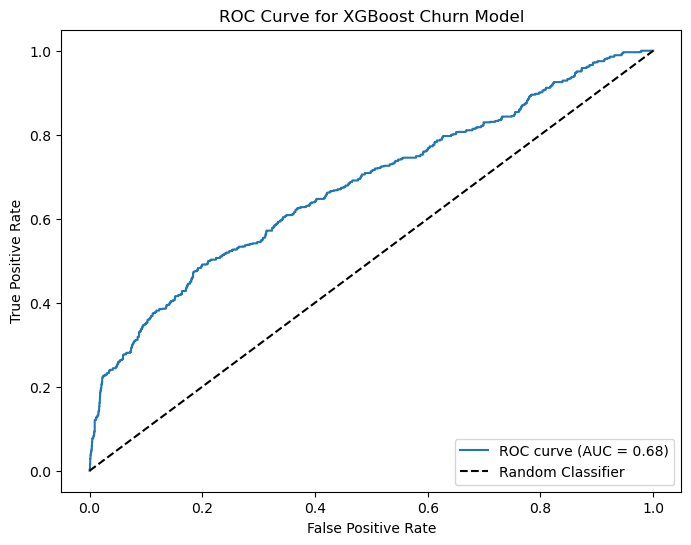

ROC AUC Score: 0.68


In [163]:
y_pred = model_xg.predict(X_test_scaled)
y_pred_proba = model_xg.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [164]:
# Classification report
print(classification_report(Y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f'F1 Score: {f1_score(Y_test, y_pred)}')

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     31649
         1.0       0.32      0.28      0.30      3373

    accuracy                           0.87     35022
   macro avg       0.62      0.61      0.61     35022
weighted avg       0.87      0.87      0.87     35022

Confusion Matrix:
 [[29682  1967]
 [ 2438   935]]
F1 Score: 0.29800796812749003


Performing hyperparameter tuning for XGboost model.

In [171]:
param_grid = {"n_estimators": [100, 200, 300], #number of helper models
             "learning_rate": [0.1, 0.05, 0.01], #contribution rate for helper models
             "max_depth": [3, 5, 8], #max depth of tree
             "subsample": [0.7, 0.8, 1.0], #percentage of training data available 
             "colsample_bytree": [0.7, 0.8, 1.0], #percentage of features available
             "scale_pos_weight": [9] #used for unbalanced dataset
}

grid_search_xg = GridSearchCV(
             estimator = XGBClassifier(eval_metric = 'logloss'),
             param_grid = param_grid,
             scoring = 'roc_auc',
             cv = 5,
             verbose = 1,
             n_jobs = -1
)

grid_search_xg.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.1, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [176]:
print(grid_search_xg.best_params_)
print(grid_search_xg.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 9, 'subsample': 0.7}
0.6906782885031666


In [173]:
best_model_xg = grid_search_xg.best_estimator_

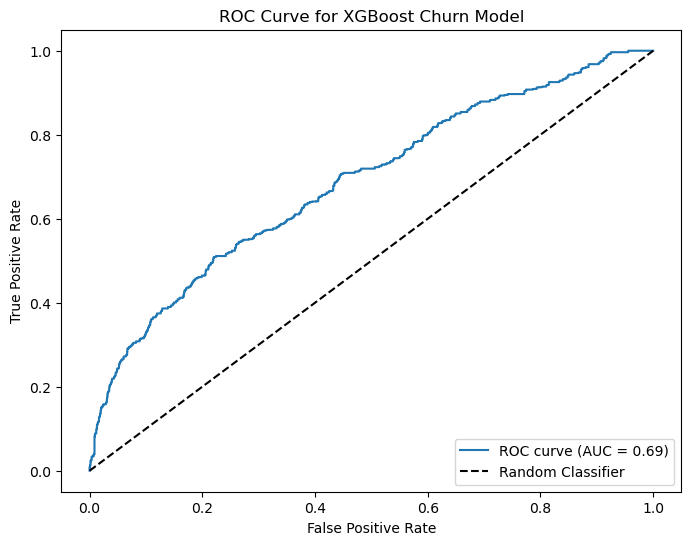

ROC AUC Score: 0.69


In [177]:
y_pred_proba = best_model_xg.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [178]:
# Predict class labels (default threshold 0.5)
y_pred = best_model_xg.predict(X_test_scaled)

# Classification report
print(classification_report(Y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f'F1 Score: {f1_score(Y_test, y_pred)}')

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84     31649
         1.0       0.19      0.51      0.27      3373

    accuracy                           0.74     35022
   macro avg       0.56      0.64      0.56     35022
weighted avg       0.86      0.74      0.79     35022

Confusion Matrix:
 [[24195  7454]
 [ 1649  1724]]
F1 Score: 0.2747191458847901


In [185]:
feature_importance = pd.DataFrame({"features": X_train.columns, 'importance': best_model_xg.feature_importances_})
feature_importance.sort_values('importance', ascending = False).head()

,features,importance
60,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,0.052923
62,origin_up_lxidpiddsbxsbosboudacockeimpuepw,0.050283
27,margin_gross_pow_ele,0.043019
51,end_month,0.032805
14,avg_fix_price,0.028505


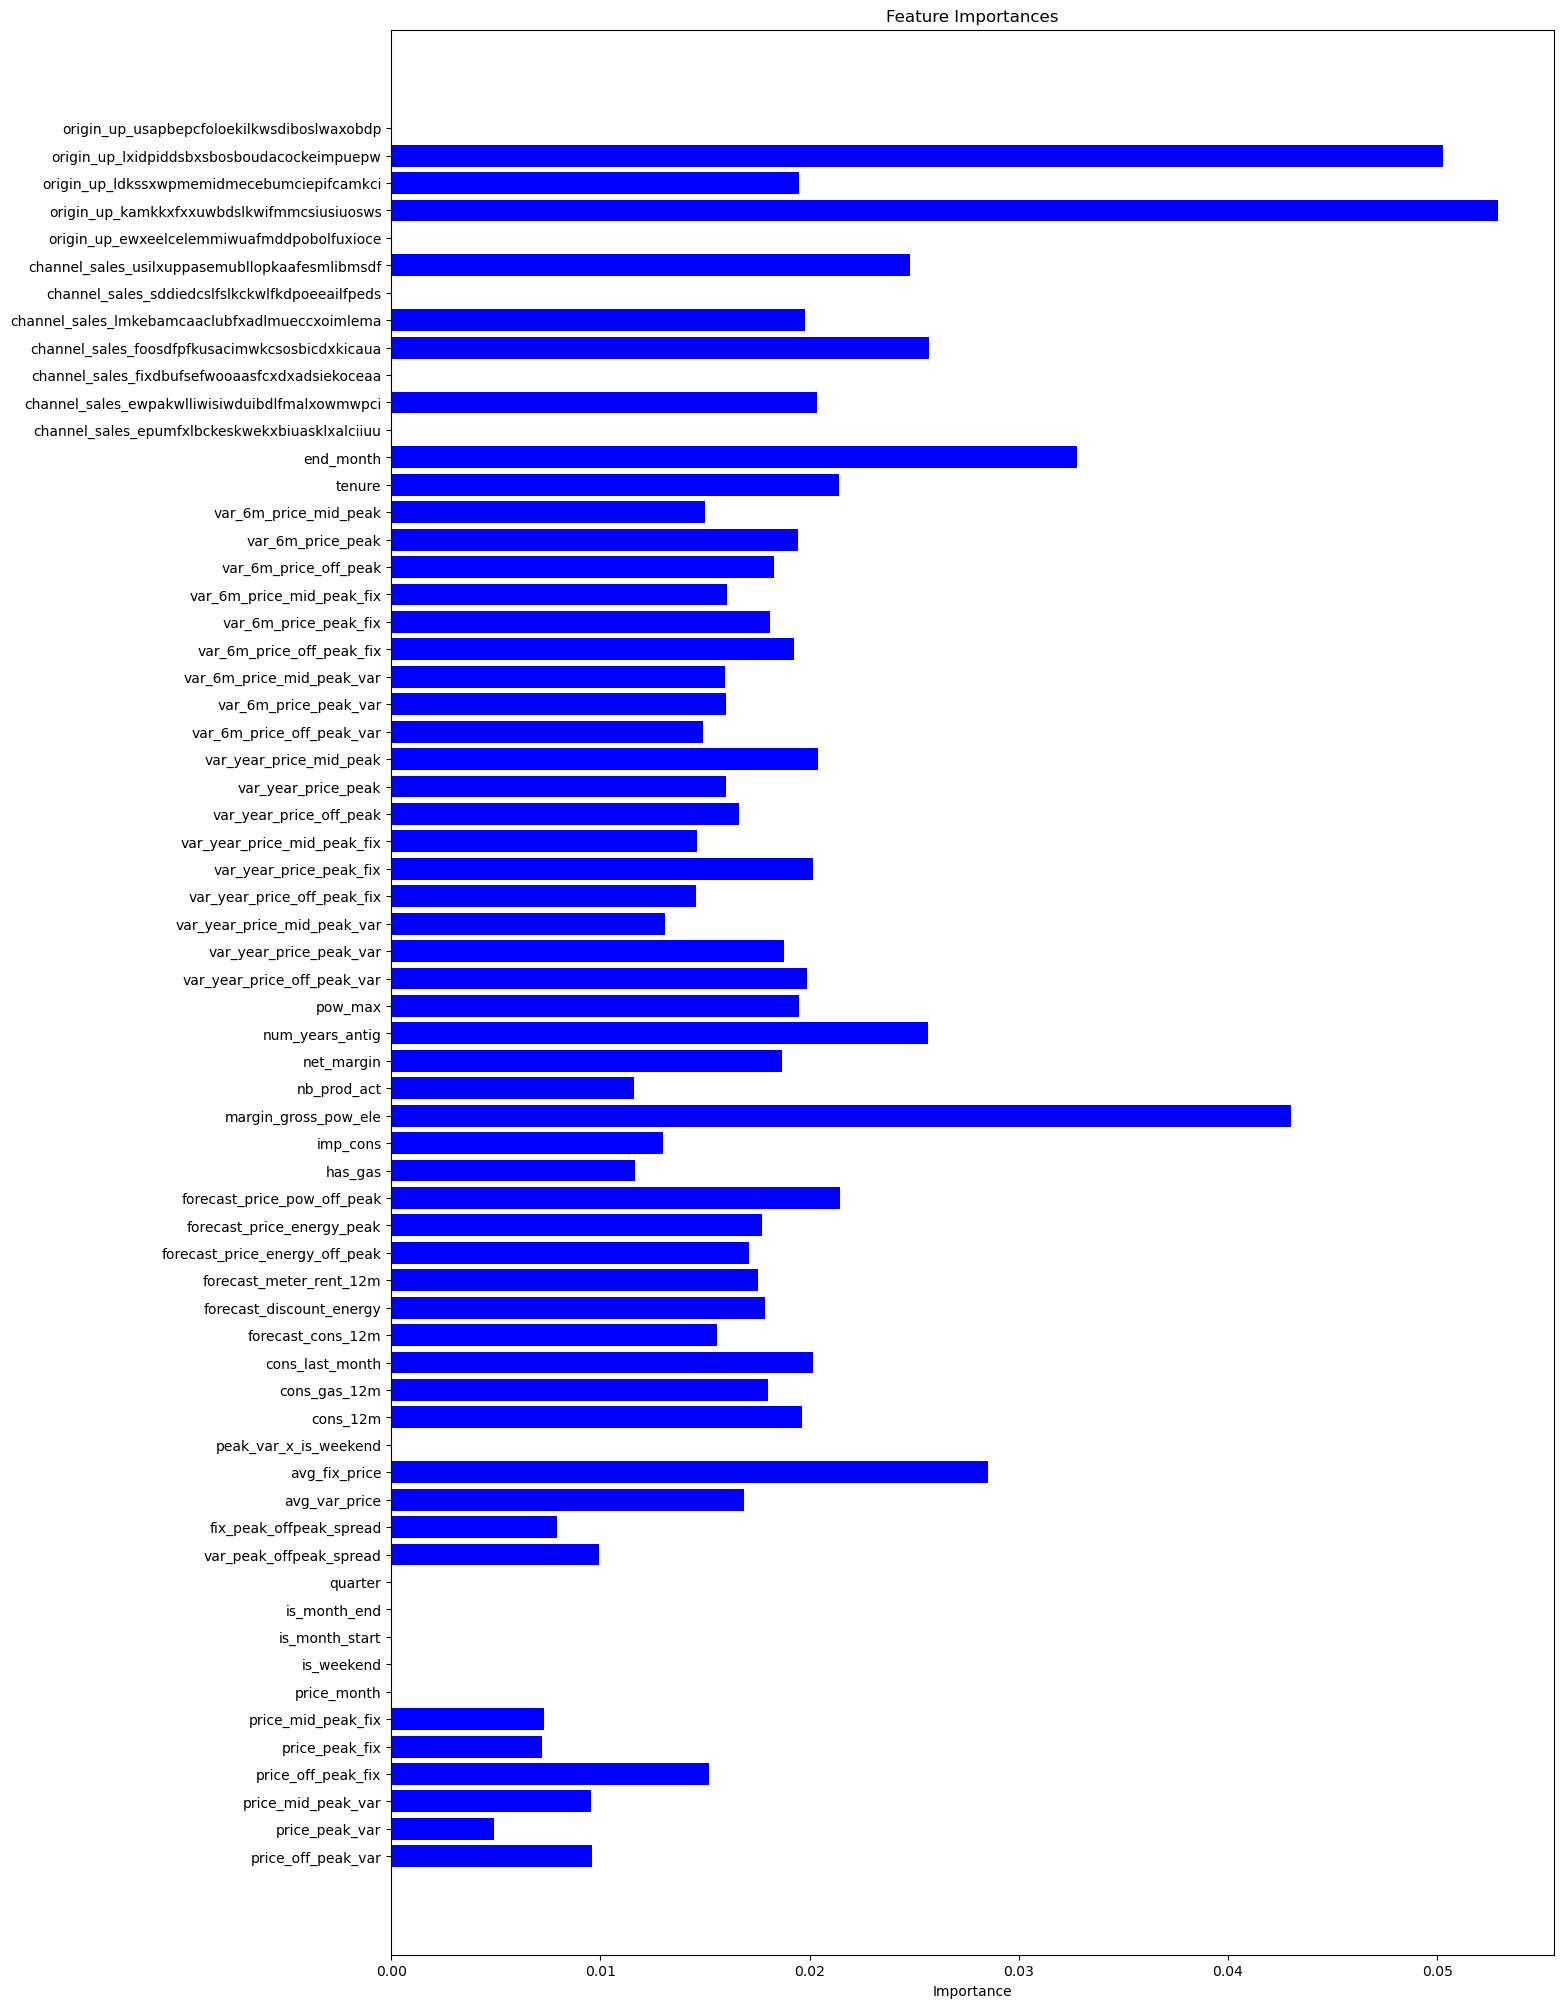

In [187]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='b', align='center')
plt.yticks(range(len(feature_importance)), feature_importance['features'])
plt.xlabel('Importance')
plt.show()

Based on the feature importance we can observe that Origin_up grouping is a major factor followed by gross margin, end month, and average price.

So, is price a good indicator for the churn prediction for PowerCO? On the basis of the above analysis, for our model top contributing factor is origin_up group and gross margin. Average price, one of the price indicator, has relative importance of 2.8% so its a relatively moderate contributor, not a top contributing factor. However, we need better feature engineer and more data to be sure.

A lot of predictors have near 0 feature importance so we would remove them for our final Xgboost model. However, while the model needs more feature engineering and data, after our analysis we can confirm that this dataset itself is limited and not usable for more feature engineering.

In [213]:
X_train_xgb = X_train.drop(columns = list(feature_importance.loc[feature_importance['importance'] == 0,].iloc[:,0]))
X_test_xgb = X_test.drop(columns = list(feature_importance.loc[feature_importance['importance'] == 0,].iloc[:,0]))

#We will not scale the parameters this time as XG Boost is invariant to it overall, we scaled to fit both XGboost and neurel network

In [218]:
model_xgb = XGBClassifier(eval_metric = 'logloss',
                          colsample_bytree = 0.7,
                          learning_rate = 0.01,
                          max_depth = 5,
                          n_estimators = 300,
                          scale_pos_weight = 9,
                          subsample = 0.7)
model_xgb.fit(X_train_xgb, Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


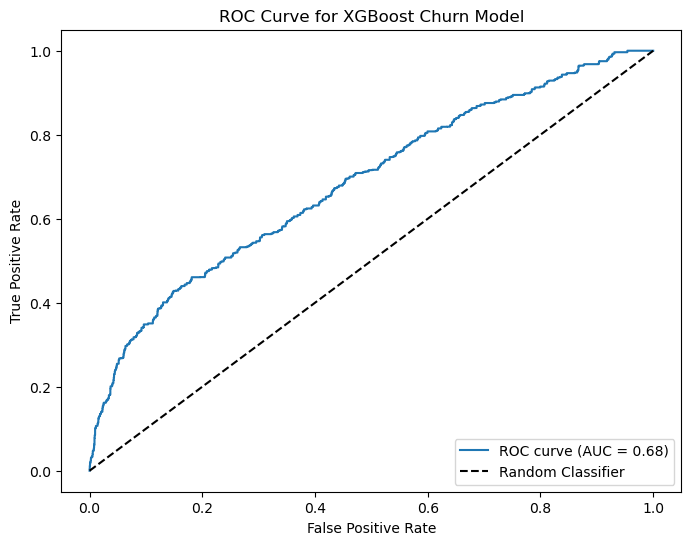

ROC AUC Score: 0.68


In [219]:
y_pred = model_xgb.predict(X_test_xgb)
y_pred_proba = model_xgb.predict_proba(X_test_xgb)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [220]:
# Predict class labels (default threshold 0.5)
y_pred = model_xgb.predict(X_test_xgb)

# Classification report
print(classification_report(Y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f'F1 Score: {f1_score(Y_test, y_pred)}')

              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84     31649
         1.0       0.18      0.50      0.27      3373

    accuracy                           0.74     35022
   macro avg       0.56      0.63      0.55     35022
weighted avg       0.86      0.74      0.79     35022

Confusion Matrix:
 [[24182  7467]
 [ 1692  1681]]
F1 Score: 0.26850890503953356


In [222]:
feature_importance = pd.DataFrame({"features": X_train_xgb.columns, 'importance': model_xgb.feature_importances_})
feature_importance.sort_values('importance', ascending = False).head()

,features,importance
52,origin_up_lxidpiddsbxsbosboudacockeimpuepw,0.058003
50,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,0.044520
21,margin_gross_pow_ele,0.041389
9,avg_fix_price,0.033047
45,end_month,0.032014


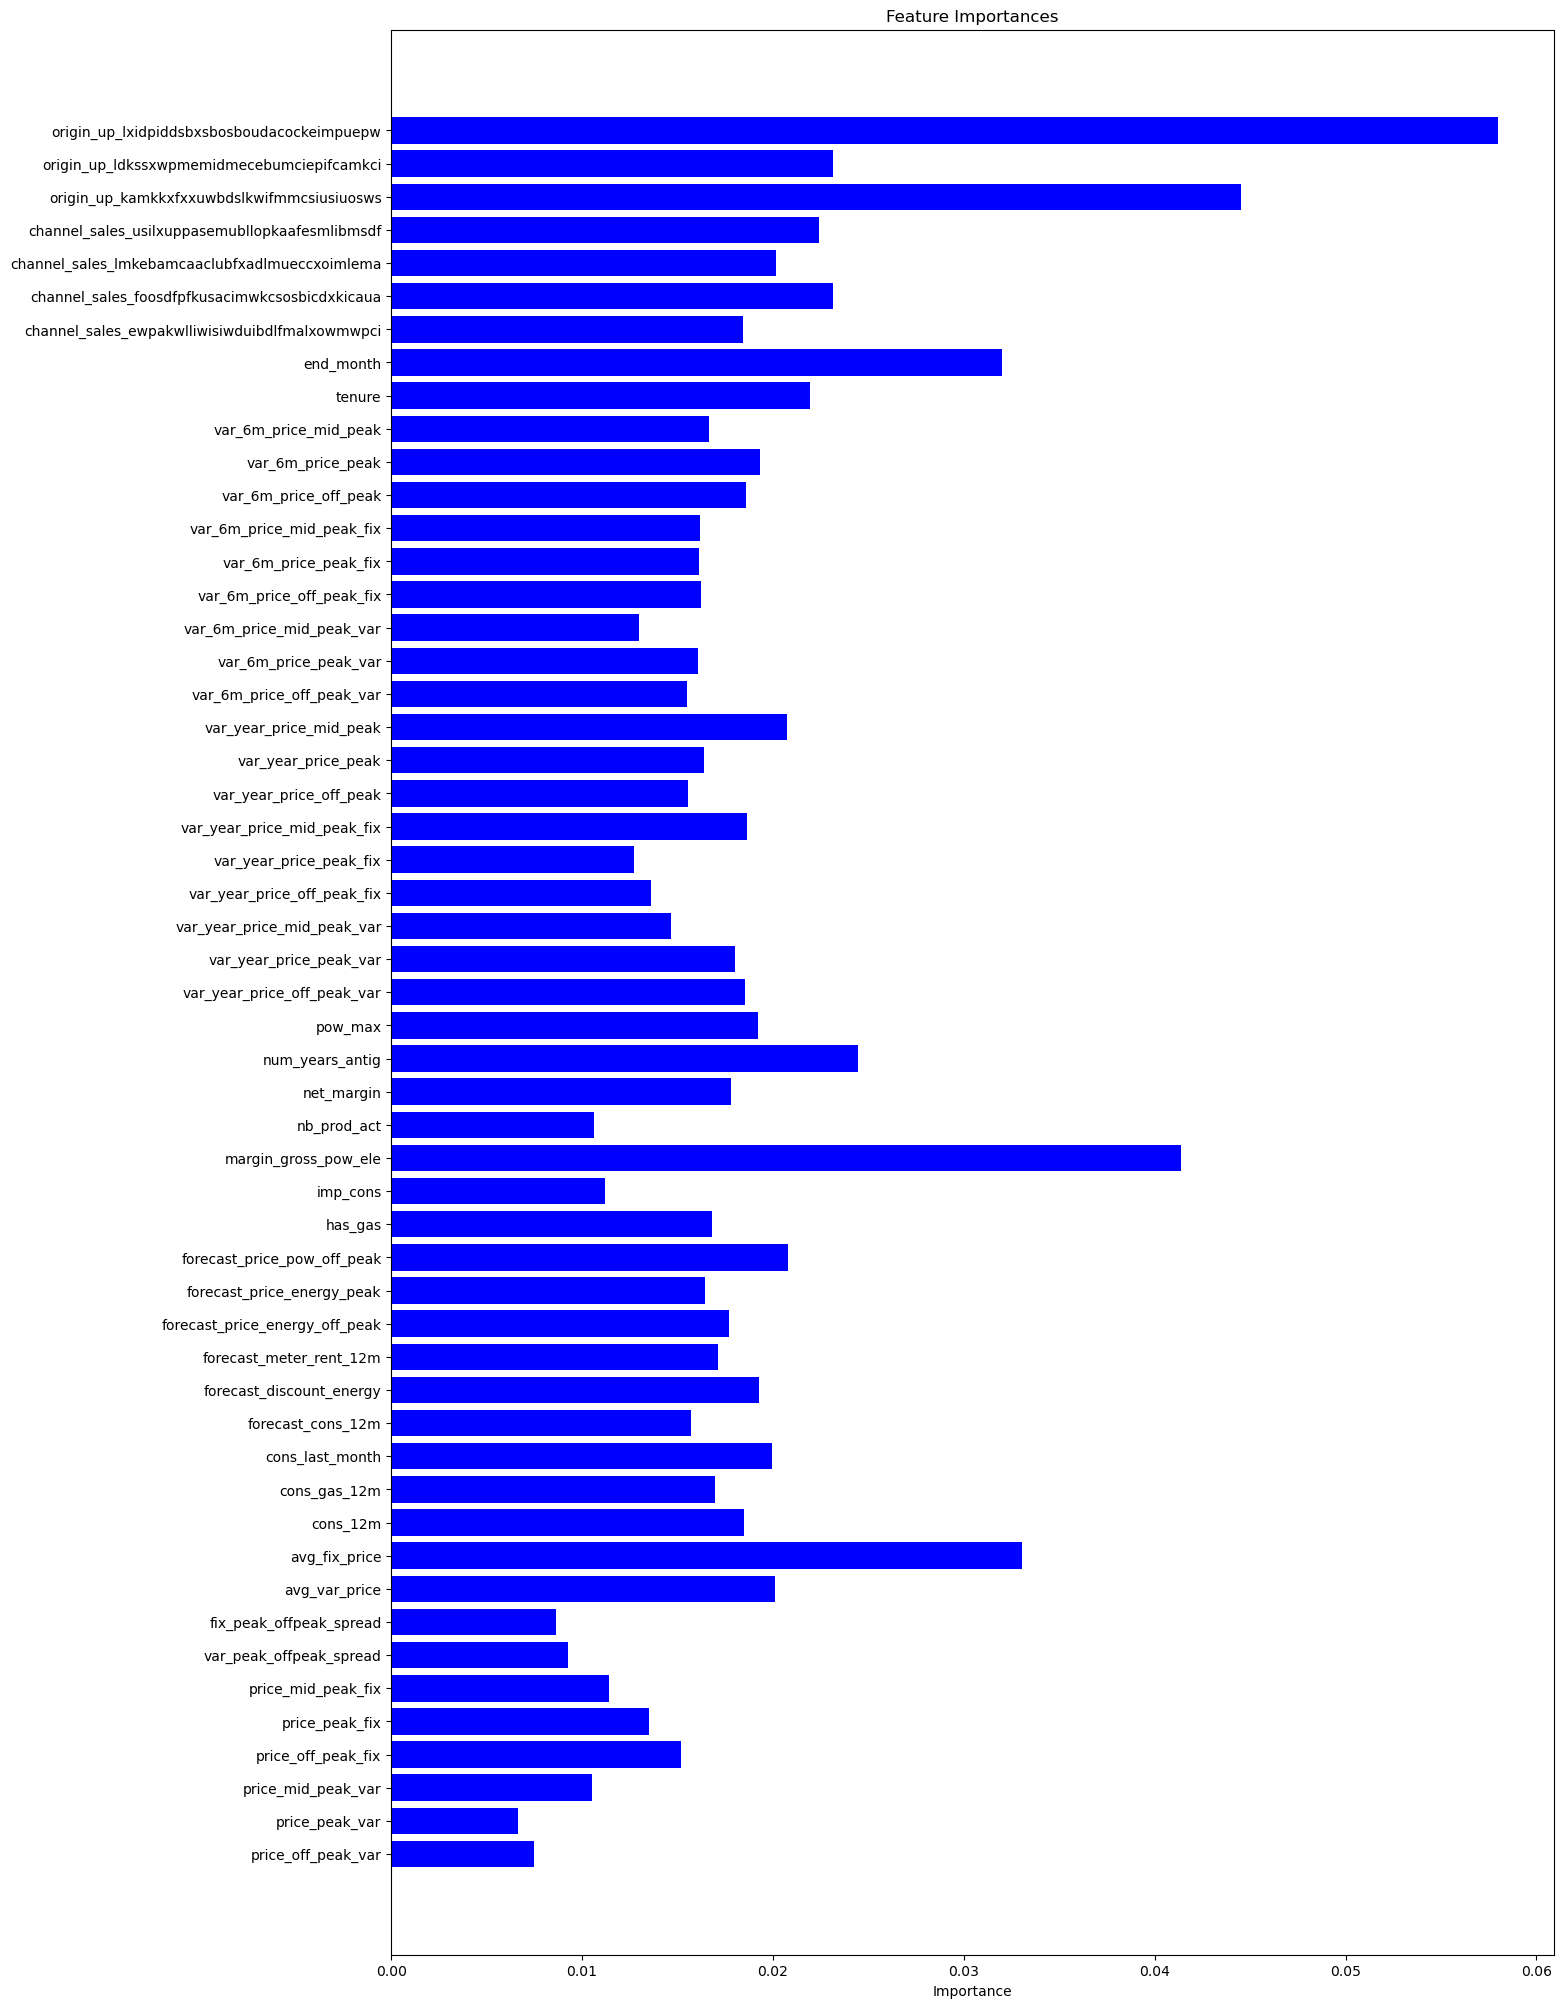

In [223]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='b', align='center')
plt.yticks(range(len(feature_importance)), feature_importance['features'])
plt.xlabel('Importance')
plt.show()

Final XGBoost model has slightly lower performance but its not that different overall as its overall ROC drops by 1% to 68%. We can use either models as both of them are better than BCGX model answer where we had 52% ROC-AUC Score. 

For feature importance we can observed that by removing redundant variables importance for most important variabled did improve. Overall, PowerCo was concerned with Churn Analysis and if price is a major churn variable. In BCGX model answer price predictors had around 2% importance but in ours we have price variable in top 5 most important feature.

Still, we can't say definitely that price impact churn in an impactful way like origin_up classification and gross margin, but still its an moderately impactful predictor for churn which does warrant further analysis. 

### Neurel Networks

In this step we will fit two tensorflow powered deep learning models. One will be based on Dense Layers based on relu actication while other will be based on BiDirectional LSTM-CNN Model.

For DNN model we will use relu activations throughout the model with proper batch normalization and weights initializer to avoid possible gradient exploding/shrinkage. And for BiLSTM-CNN model we will be using padding and masking for the time series data. 

In [228]:
#Checking GPU availability

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

hello = tf.constant("Hello TensorFlow!")
print(hello.numpy())  

Num GPUs Available:  1
b'Hello TensorFlow!'


In [232]:
X_train.shape[1]

64

In [248]:
#DNN Based model

model_dnn = Sequential([
    Dense(32, input_dim = X_train.shape[1], kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(64, kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(128, kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(64, kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(32, kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(16, kernel_initializer = HeNormal()),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation = 'linear')
])

In [249]:
model_dnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,737 (96.63 KB)

 Trainable params: 24,065 (94.00 KB)

 Non-trainable params: 672 (2.62 KB)

In [247]:
early_stopping = EarlyStopping(monitor = 'val_AUC', patience = 10, restore_best_weights=True)

In [250]:
model_dnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ['accuracy', 'AUC'])
model_dnn.fit(X_train_scaled, Y_train, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - AUC: 0.5030 - accuracy: 0.8685 - loss: 0.4226 - val_AUC: 0.5008 - val_accuracy: 0.9114 - val_loss: 0.2919
Epoch 2/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - AUC: 0.5277 - accuracy: 0.9022 - loss: 0.2915 - val_AUC: 0.5298 - val_accuracy: 0.9094 - val_loss: 0.2960
Epoch 3/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - AUC: 0.5614 - accuracy: 0.9070 - loss: 0.2739 - val_AUC: 0.5341 - val_accuracy: 0.9092 - val_loss: 0.2963
Epoch 4/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - AUC: 0.5848 - accuracy: 0.9120 - loss: 0.2571 - val_AUC: 0.5480 - val_accuracy: 0.9114 - val_loss: 0.3088
Epoch 5/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - AUC: 0.6026 - accuracy: 0.9128 - loss: 0.2520 - val_AUC: 0.5701 - val_accuracy: 0.9137 - val_loss: 0.3099
Epoch 6/100
3504/3504 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - AUC: 0.6247 - accuracy: 0.9183 - loss: 0.2343 - val_AUC: 0.5574 - val_accuracy: 0.9111 - val_loss: 0.3295
Epoch 7/100
3504

In [ ]:
y_pred = model_dnn.predict(X_test_xgb)
y_pred_proba = model_xgb.predict_proba(X_test_xgb)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


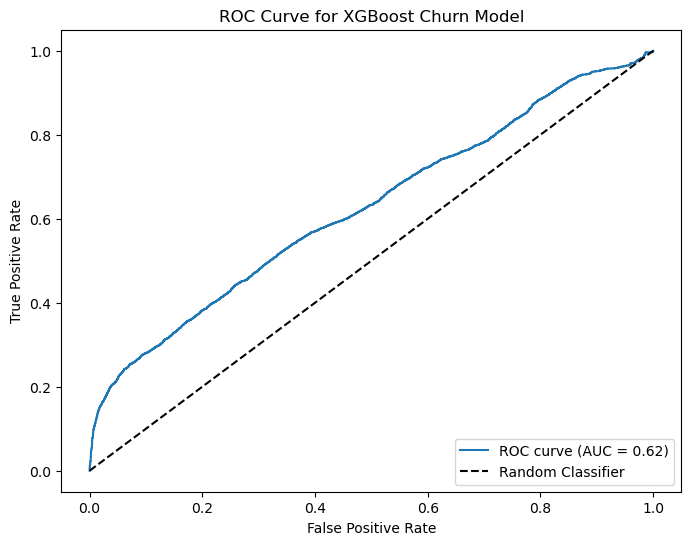

ROC AUC Score: 0.62


In [341]:
y_pred = tf.nn.sigmoid(model_dnn.predict(X_test_scaled)) > 0.5
y_pred_proba = tf.nn.sigmoid(model_dnn.predict(X_test_scaled))

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [264]:
# Classification report
print(classification_report(Y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f'F1 Score: {f1_score(Y_test, y_pred)}')

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     31649
         1.0       0.38      0.19      0.25      3373

    accuracy                           0.89     35022
   macro avg       0.65      0.58      0.60     35022
weighted avg       0.87      0.89      0.88     35022

Confusion Matrix:
 [[30632  1017]
 [ 2742   631]]
F1 Score: 0.2513443537143995


Our DNN model didn't work better than gradient boosting. Even when focus was done on AUC score on training we got a model with very less recall overall compared to XGBoosting algorithm.

Now we will fit a BiLSTM-CNN model based on the research paper: Customer churn prediction using composite deep learning technique Link: https://www.nature.com/articles/s41598-023-44396-w#:~:text=A%20composite%20deep%20learning%20model,dataset%20for%20predicting%20customer%20attrition

For this model we need timestamps as its based on LSTM layers and since we have 12 month data for each clients we can use this model effectively. Only concern here is the lack of proper 12 month data for churned clients as we can not source more data from BCGX, to fill this gap we will use Zero Padding for churned clients missing some monthly data and proper masking during the model training.

In [300]:
# Ensure data is sorted by client and month
df_merge_dm = df_merge.sort_values(['id', 'price_month'])

# List of all clients
clients = df_merge_dm['id'].unique()
num_clients = len(clients)
num_months = 12
num_features = 63

# List of feature columns (replace with your actual feature names)
feature_cols = [col for col in df_merge_dm.columns if col not in ['id', 'price_month', 'churn']]

# Initialize arrays
X = np.zeros((num_clients, num_months, num_features))
y = np.zeros(num_clients)

for i, client in enumerate(clients):
    client_data = df_merge_dm[df_merge_dm['id'] == client].sort_values('price_month')
    # Get feature values
    features = client_data[feature_cols].values
    # Zero pad if less than 12 months
    if features.shape[0] < num_months:
        padded = np.zeros((num_months, num_features))
        padded[-features.shape[0]:, :] = features  # pad at the start, keep recent months at the end
    else:
        padded = features[-num_months:, :]  # take last 12 months if more
    X[i] = padded
    y[i] = client_data['churn'].iloc[-1] 


In [298]:
#BiLSTM-CNN Model. It is based on the research paper mentioned before

inputs = Input(shape=(num_months, num_features))
x = Masking(mask_value=0.0)(inputs)
x = Bidirectional(LSTM(64, return_sequences = True))(x)
x = Conv1D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', 'AUC'])
model.summary()

(175149, 66)

In [308]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 10) 

In [316]:
num_clients, num_months, num_features = X_train.shape

# Reshape to 2D for scaling
X_2d = X_train.reshape(-1, num_features)  # shape: (num_clients * num_months, num_features)

# Fit scaler on training data only!
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

# Reshape back to 3D
X_train_scaled = X_2d_scaled.reshape(num_clients, num_months, num_features)

In [329]:
timesteps = 12
n_features = 63

inputs = tf.keras.Input(shape=(timesteps, n_features))

inputs = Input(shape=(num_months, num_features))
x = Masking(mask_value=0.0)(inputs) #masking for padded data
x = Bidirectional(LSTM(64, return_sequences=True))(x) #Bi-directional LSTM  layer
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x) #Convolutional Layer
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 12, 63)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 12, 63)    │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 12, 63)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 12)        │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 12, 128)   │     65,536 │ masking_2[0][0],  │
│ (Bidirectional)     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 12, 32)    │     12,320 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │      2,112 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,033 (312.63 KB)

 Trainable params: 80,033 (312.63 KB)

 Non-trainable params: 0 (0.00 B)

In [330]:
history = model.fit(X_train_scaled, Y_train, epochs = 50, 
                    batch_size = 32, validation_split = 0.2, 
                    callbacks = [EarlyStopping(monitor = 'val_AUC', patience = 10, restore_best_weights = True, mode = 'max')])

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8871 - auc: 0.5489 - loss: 0.3576 - precision_5: 0.0792 - recall_5: 0.0198 - val_accuracy: 0.9050 - val_auc: 0.6017 - val_loss: 0.3111 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9043 - auc: 0.6372 - loss: 0.3060 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9050 - val_auc: 0.6376 - val_loss: 0.3082 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9076 - auc: 0.6641 - loss: 0.2959 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.9050 - val_auc: 0.6300 - val_loss: 0.3084 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9074 - auc: 0.7159 - loss: 0.2814 - precision_5: 0.6334 - recall_5: 0.0051 - val_accuracy: 0.9029 - val_auc: 0.6440 - val_loss: 0.3053 - va

In [331]:
num_clients, num_months, num_features = X_test.shape

# Reshape to 2D for scaling
X_2d = X_test.reshape(-1, num_features)  # shape: (num_clients * num_months, num_features)

# Fit scaler on training data only!
X_2d_scaled = scaler.transform(X_2d)

# Reshape back to 3D
X_test_scaled = X_2d_scaled.reshape(num_clients, num_months, num_features)

In [335]:
Y_test.mean()

np.float64(0.10130047912388775)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 


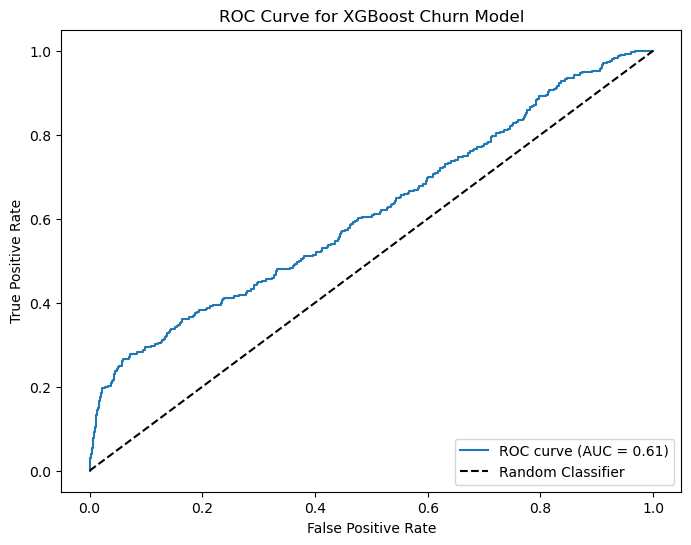

ROC AUC Score: 0.61


In [337]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
y_pred_proba = model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Churn Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.2f}")

In [338]:
# Classification report
print(classification_report(Y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f'F1 Score: {f1_score(Y_test, y_pred)}')

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      2626
         1.0       0.45      0.20      0.28       296

    accuracy                           0.89      2922
   macro avg       0.68      0.59      0.61      2922
weighted avg       0.87      0.89      0.88      2922

Confusion Matrix:
 [[2554   72]
 [ 237   59]]
F1 Score: 0.27634660421545665


-----
## Conclusion

BiDirectional LSTM-CNN Model worked better than DNN we covered before. Summary for metrics for three models:

#### Model Performance Comparison

| Model        | F1 Score         | Recall        | ROC-AUC | Accuracy |
|--------------|------------------|---------------|---------|----------|
| BiLSTM-CNN   | 0.28             | 0.20          | 0.61    | 0.89     |
| DNN          | 0.25             | 0.19          | 0.62    | 0.89     |
| XGBoost      | 0.27             | 0.50          | 0.69    | 0.74     |

BiLSTM-CNN has highest F1 score among the three models we tested, however it has low AUC score and recall compared to Gradient Boost model. Generally, Gradient Boosting is considered industry standard for churn analysis and through this result we can observe that it is indeed better in getting higher recall which is essential for churn prediction.

This project was started with the client hypothesis that Price is a major factor leading to churn. Since XGBoost Model is best model here we used feature importance for that model and found that sale promotion id or group is most important factor leading to churn, solidiying our findings during EDA that proportion of churn for some subgroups of clients were higher than usual. Price was a reasonable factor, but not a major one as even margin is better indicator.

We got best model F1 score at 0.27 and recall of 0.50 with ROC-AUC score at 0.69. While accuracy is not important its 0.74 for XGBoost model, its not high but since we focused on improving ROC scores on all models it was acceptable trade. All of our models worked a lot better than BCGX model answer where we had F1 Score of 0.09, recall of 0.05, and ROC score of 0.52.

We can get better model performance but for that we need more data and better feature engineering which is not possible with the dataset in hand. Also, while both DNN Model and BiLSTM-CNN model underperformed compared to Gradient Boost model because they do not work good with such tabular data in general, it is to be noted that in scenario where we have a large amount of data both of these models could work better. And we can even use a mix of Gradient Boosting and BiLSTM-CNN models by using ensemble methods on BiLSTM-CNN model.